In [1]:
import xarray as xr
import pandas as pd
import numpy as np

In [2]:
ds = xr.open_dataset('pnwrain.50km.daily.4994.nc', decode_times=False)

In [3]:
ds.info()

xarray.Dataset {
dimensions:
	lat = 17 ;
	lon = 16 ;
	time = 16801 ;

variables:
	float32 lat(lat) ;
		lat:title = Latitude ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:title = Longitude ;
		lon:units = degrees_east ;
	float64 time(time) ;
		time:title = Time ;
		time:units = days    since 1949- 1- 1  0: 0: 0 ;
	float32 data(time, lat, lon) ;
		data:long_name = mm/day ;
		data:units = mm/day ;

// global attributes:
}

### Manually decode time variable since it fails when opening dataset

the extra spaces of the attribute unit string of the time variable is causing this issue

In [4]:
print(ds['time'])

<xarray.DataArray 'time' (time: 16801)>
array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 1.6798e+04, 1.6799e+04,
       1.6800e+04])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 1.68e+04 1.68e+04 1.68e+04
Attributes:
    title:    Time
    units:    days    since 1949- 1- 1  0: 0: 0


Extract time values and units

In [5]:
time_values = ds.time.values

# Empty spaces in the unit string will cause issue on num2date function
# time_units = ds.time.attrs['units']

In [6]:
# Manually Parse the units string instead
reference_date = '1949-01-01 00:00:00'
time_units = 'days since ' + reference_date

Decode time values (assume Gregorian calendar )

In [7]:
from cftime import num2date

time_index = num2date(time_values, units=time_units)

In [8]:
# Create a Dataset with the time_index variable
time_ds = xr.Dataset({'time_index': ('time', time_index)})

# Merge the time_ds Dataset with the original dataset
ds = xr.merge([ds, time_ds], combine_attrs='override')

In [9]:
# Set 'time_index' as the new coordinate for 'time'
ds = ds.assign_coords({'time': ds['time_index']})

In [10]:
ds = ds.drop_vars('time_index')

In [11]:
ds['time'].attrs = {
    'title': 'Time',
    'units': 'days since 1949-01-01 00:00:00'
}

In [12]:
# convert cftime.DatetimeGregorian to datetime
datetimeindex = ds.indexes['time'].to_datetimeindex()
ds['time'] = datetimeindex

In [13]:
# Set time as the index
ds = ds.set_index(time='time')

In [14]:
ds.info()

xarray.Dataset {
dimensions:
	lat = 17 ;
	lon = 16 ;
	time = 16801 ;

variables:
	float32 lat(lat) ;
		lat:title = Latitude ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:title = Longitude ;
		lon:units = degrees_east ;
	datetime64[ns] time(time) ;
	float32 data(time, lat, lon) ;
		data:long_name = mm/day ;
		data:units = mm/day ;

// global attributes:
}

Check gap in dates

In [15]:
# Calculate the differences between consecutive time points
time_diff = ds['time'].diff(dim='time')

# Convert time differences to a more interpretable format, like days
time_diff_in_days = time_diff / pd.to_timedelta(1, unit='D')

In [408]:
# more than 1 day is consider a gap
large_gap_threshold = 1  # days

# Find where the gaps exceed this threshold
large_gaps = time_diff_in_days.where(time_diff_in_days > large_gap_threshold, drop=True)

In [409]:
# Check if there are gaps
if len(large_gaps) > 0:
    print("Large gaps found at the following times:")
    print(large_gaps)
else:
    print("No large gaps found in the dates.")

No large gaps found in the dates.


Flatten data

In [16]:
# Stack 'lat' and 'lon' to create a single 'spatial' dimension
data_flat = ds['data'].stack(all_points=('time', 'lat', 'lon'))

In [17]:
data_flat

<xarray.DataArray 'data' (all_points: 4569872)>
array([nan, nan, nan, ..., 7.4, nan, nan], dtype=float32)
Coordinates:
  * all_points  (all_points) object MultiIndex
  * time        (all_points) datetime64[ns] 1949-01-01 1949-01-01 ... 1994-12-31
  * lat         (all_points) float32 49.76 49.76 49.76 ... 42.14 42.14 42.14
  * lon         (all_points) float32 -125.6 -125.0 -124.4 ... -116.9 -116.2
Attributes:
    long_name:  mm/day
    units:      mm/day

In [18]:
df_flat = data_flat.to_dataframe(name='precipitation').reset_index(drop=True)

In [19]:
print(df_flat.columns)

Index(['time', 'lat', 'lon', 'precipitation'], dtype='object')


In [20]:
df_flat.head(10)

,time,lat,lon,precipitation
0,1949-01-01,49.760941,-125.625,NaN
1,1949-01-01,49.760941,-125.000,NaN
2,1949-01-01,49.760941,-124.375,NaN
3,1949-01-01,49.760941,-123.750,NaN
4,1949-01-01,49.760941,-123.125,NaN
5,1949-01-01,49.760941,-122.500,NaN
6,1949-01-01,49.760941,-121.875,NaN
7,1949-01-01,49.760941,-121.250,NaN
8,1949-01-01,49.760941,-120.625,NaN
9,1949-01-01,49.760941,-120.000,NaN


## Handle missing value in data

In [21]:
df_flat['precipitation']

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
             ...    
4569867    23.900000
4569868    25.800001
4569869     7.400000
4569870          NaN
4569871          NaN
Name: precipitation, Length: 4569872, dtype: float32

In [22]:
df_flat['precipitation'].isnull().sum()

1439154

In [23]:
precipitation_zero = df_flat[df_flat['precipitation'] == 0]
print(precipitation_zero)

              time        lat      lon  precipitation
42      1949-01-01  48.808578 -119.375            0.0
43      1949-01-01  48.808578 -118.750            0.0
58      1949-01-01  48.332401 -119.375            0.0
59      1949-01-01  48.332401 -118.750            0.0
73      1949-01-01  47.856220 -120.000            0.0
...            ...        ...      ...            ...
4569860 1994-12-31  42.142059 -123.125            0.0
4569861 1994-12-31  42.142059 -122.500            0.0
4569864 1994-12-31  42.142059 -120.625            0.0
4569865 1994-12-31  42.142059 -120.000            0.0
4569866 1994-12-31  42.142059 -119.375            0.0

[1800839 rows x 4 columns]


Filling with 0

In [418]:
# df_flat['precipitation'].fillna(0, inplace=True)

Resample

In [419]:
# df_flatten = df_flat.copy()

In [420]:
# # Convert 'time' column to datetime format if it's not already
# df_flatten['time'] = pd.to_datetime(df_flatten['time'])

# # Set 'time' column as the index
# df_flatten.set_index(['time'], inplace=True)

In [421]:
# # Resample to monthly frequency and calculate the mean precipitation
# monthly_mean_precipitation = df_flatten['precipitation'].resample('M').mean()

# # Resample to weekly frequency and calculate the sum precipitation
# weekly_sum_precipitation = df_flatten['precipitation'].resample('W').sum()

Spatial Interpolation

In [24]:
df_flatten = df_flat.copy()

IDW

In [423]:
# from scipy.interpolate import Rbf

# # IDW interpolation
# def idw_interpolation(df, time, lat, lon):
#     # Filter data for the specific time point
#     df_time = df[df['time'] == time]
    
#     # Filter out NaN values and create arrays for lat, lon, and precipitation
#     lat_known = df_time['lat'][~df_time['precipitation'].isnull()].values
#     lon_known = df_time['lon'][~df_time['precipitation'].isnull()].values
#     prec_known = df_time['precipitation'][~df_time['precipitation'].isnull()].values
    
#     # Perform IDW interpolation
#     rbfi = Rbf(lon_known, lat_known, prec_known, function='linear')
#     interp_prec = rbfi(lon, lat)
    
#     return interp_prec

In [424]:
# # Find indices of NaN values in the 'precipitation' column
# nan_indices = df_flatten[df_flatten['precipitation'].isnull()].index

# # Fill NaN values using IDW interpolation
# for idx in nan_indices:
#     time = df_flatten.loc[idx, 'time']
#     lat = df_flatten.loc[idx, 'lat']
#     lon = df_flatten.loc[idx, 'lon']
#     interpolated_prec = idw_interpolation(df_flatten, time, lat, lon)
#     df_flatten.loc[idx, 'precipitation'] = interpolated_prec


Kriging

In [425]:
# from pykrige.ok import OrdinaryKriging

# def kriging_interpolation(df, time, lat, lon):
#     # Filter data to include only non-NaN values
#     df_filtered = df.dropna(subset=['precipitation'])
    
#     # Extract coordinates and values
#     X = df_filtered[['lon', 'lat', 'time']].values
#     values = df_filtered['precipitation'].values
    
#     # Perform kriging interpolation
#     OK = OrdinaryKriging(
#         X[:, 0], X[:, 1], values,
#         variogram_model='linear', # Specify the variogram model here
#         verbose=False, enable_plotting=False
#     )
#     interpolated_prec, _ = OK.execute('points', lon, lat, time)
    
#     # Update the 'precipitation' value in the DataFrame
#     df.loc[df['time'] == time, 'precipitation'] = interpolated_prec
    
#     return df


KNN Imputation (Take Long To Run)

In [ ]:
from scipy.spatial import cKDTree

# Convert 'time' column to Unix timestamps (seconds since the Unix epoch)
df_flatten['time_unix'] = df_flatten['time'].astype(np.int64) // 10**9

# Find indices of NaN values in the 'precipitation' column
nan_indices = df_flatten[df_flatten['precipitation'].isnull()].index

# Filter out rows with NaN values
df_filtered = df_flatten.dropna(subset=['lon', 'lat', 'time_unix', 'precipitation'])

# KDTree for nearest neighbor search
tree = cKDTree(df_filtered[['lon', 'lat', 'time_unix']].values)

# Batch size
batch_size = 1000

# Process NaN values in batches
for i in range(0, len(nan_indices), batch_size):
    batch_indices = nan_indices[i:i+batch_size]
    for idx in batch_indices:
        time = df_flatten.loc[idx, 'time_unix']
        lat = df_flatten.loc[idx, 'lat']
        lon = df_flatten.loc[idx, 'lon']
    
        # Find the nearest neighbor
        _, ind = tree.query([lon, lat, time], k=1)
        if isinstance(ind, int):  # Convert to list if it's an integer
            ind = [ind]
        neighbor_idx = df_filtered.iloc[ind[0]].name
    
        # Interpolate the missing value using the neighbor's value
        df_flatten.loc[idx, 'precipitation'] = df_filtered.loc[neighbor_idx, 'precipitation']

    # Print progress
    batches_completed = (i + batch_size) // batch_size
    batches_left = (len(nan_indices) + batch_size - 1) // batch_size - batches_completed
    print(f"Processed {batches_completed}/{len(nan_indices) // batch_size} batches. {batches_left} batches left.")

print("Remaining NaN count:", df_flatten['precipitation'].isnull().sum())

In [25]:
df_flatten['precipitation'].isnull().sum()

1439154

In [26]:
if df_flatten['precipitation'].isnull().sum() == 0:
    print("All NaN values filled successfully.")
else:
    print("Some NaN values remain after interpolation.")

Some NaN values remain after interpolation.


In [27]:
# Check for any duplicate rows based on all columns
duplicate_rows = df_flat.duplicated()
print("Number of duplicate rows:", duplicate_rows.sum())

# To see the actual duplicate rows
if duplicate_rows.sum() > 0:
    print(df_flat[duplicate_rows])

Number of duplicate rows: 0


In [ ]:
# df_flatten.to_csv('nn_filled_precipitation.csv')

Load the KNN interpolated data

In [28]:
df_flatten = pd.read_csv('../nn_filled_precipitation.csv')

Check duplicated rows

In [29]:
df_flatten = df_flatten.drop(['Unnamed: 0', 'time_unix'], axis=1)

df_flat = df_flatten.copy()

In [30]:
df_flat

,time,lat,lon,precipitation
0,1949-01-01,49.76094,-125.625,12.451237
1,1949-01-01,49.76094,-125.000,10.839300
2,1949-01-01,49.76094,-124.375,9.390542
3,1949-01-01,49.76094,-123.750,7.837927
4,1949-01-01,49.76094,-123.125,6.168290
...,...,...,...,...
4569867,1994-12-31,42.14206,-118.750,23.900000
4569868,1994-12-31,42.14206,-118.125,25.800001
4569869,1994-12-31,42.14206,-117.500,7.400000
4569870,1994-12-31,42.14206,-116.875,0.000000


Get ranges

In [431]:
min_date = df_flat['time'].min()
max_date = df_flat['time'].max()

print(f"The dataset covers from {min_date} to {max_date}.")

The dataset covers from 1949-01-01 to 1994-12-31.


In [432]:
# latitude
min_lat = df_flat['lat'].min()
max_lat = df_flat['lat'].max()

# longitude
min_lon = df_flat['lon'].min()
max_lon = df_flat['lon'].max()

print(f"The latitude range of the dataset is from {min_lat} to {max_lat}.")
print(f"The longitude range of the dataset is from {min_lon} to {max_lon}.")

The latitude range of the dataset is from 42.14206 to 49.76094.
The longitude range of the dataset is from -125.625 to -116.25.


## Features

In [31]:
def derive_temporal_features(df):
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['week_of_year'] = df['time'].dt.isocalendar().week
    df['day_of_week'] = df['time'].dt.dayofweek
    df['day_of_year'] = df['time'].dt.dayofyear
    df['quarter'] = df['time'].dt.quarter

    df['season'] = df['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Fall')
    df['season'] = df['season'].astype('category')

    # Cyclical features
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    return df

In [32]:
df_flat['time'] = pd.to_datetime(df_flat['time'])

In [33]:
df_flat = derive_temporal_features(df_flat)

In [34]:
df_flat

,time,lat,lon,precipitation,year,month,day,week_of_year,day_of_week,day_of_year,quarter,season,month_cos,day_of_week_cos
0,1949-01-01,49.76094,-125.625,12.451237,1949,1,1,53,5,1,1,Winter,0.866025,-0.222521
1,1949-01-01,49.76094,-125.000,10.839300,1949,1,1,53,5,1,1,Winter,0.866025,-0.222521
2,1949-01-01,49.76094,-124.375,9.390542,1949,1,1,53,5,1,1,Winter,0.866025,-0.222521
3,1949-01-01,49.76094,-123.750,7.837927,1949,1,1,53,5,1,1,Winter,0.866025,-0.222521
4,1949-01-01,49.76094,-123.125,6.168290,1949,1,1,53,5,1,1,Winter,0.866025,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4569867,1994-12-31,42.14206,-118.750,23.900000,1994,12,31,52,5,365,4,Winter,1.000000,-0.222521
4569868,1994-12-31,42.14206,-118.125,25.800001,1994,12,31,52,5,365,4,Winter,1.000000,-0.222521
4569869,1994-12-31,42.14206,-117.500,7.400000,1994,12,31,52,5,365,4,Winter,1.000000,-0.222521
4569870,1994-12-31,42.14206,-116.875,0.000000,1994,12,31,52,5,365,4,Winter,1.000000,-0.222521


Check Non zero

In [35]:
len(df_flat)

4569872

In [36]:
non_zero_precipitation_count = df_flat[df_flat['precipitation'].notna() & (df_flat['precipitation'] != 0)].shape[0]

In [37]:
non_zero_precipitation_count

2120818

Extract non zero df

In [38]:
df_non_zero = df_flat[df_flat['precipitation'] > 0.0]

# Visualization

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature

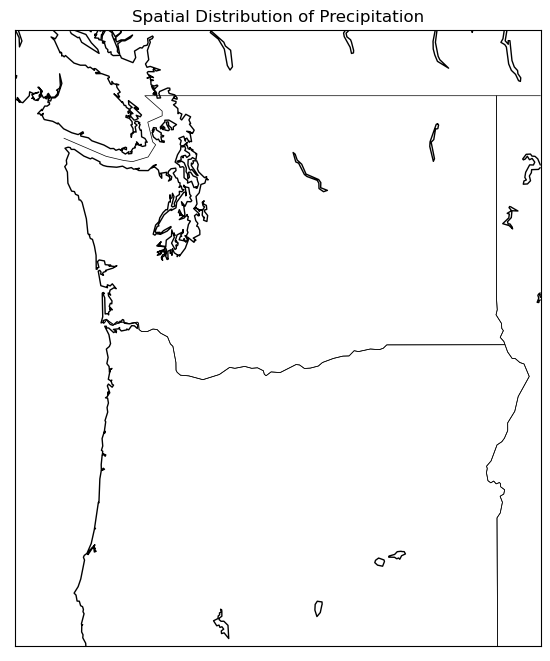

In [ ]:
# Define the boundaries of the map and resolution
fig, ax = plt.subplots(figsize=(10, 8))
m = Basemap(projection='merc', llcrnrlat=df_flat['lat'].min(), urcrnrlat=df_flat['lat'].max(),
            llcrnrlon=df_flat['lon'].min(), urcrnrlon=df_flat['lon'].max(), resolution='i')

m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Convert lat and lon to map projection coordinates
lons, lats = m(df_flat['lon'].values, df_flat['lat'].values)

plt.title('Spatial Distribution of Precipitation')
plt.show()

### Functions

In [ ]:
def filter_data(df, min_lon, max_lon, min_lat, max_lat):
    """
    Filters the DataFrame for non-zero precipitation and within the specified bounds.

    Parameters:
    - df: pandas DataFrame containing the dataset
    - min_lon, max_lon: Minimum and maximum longitude of the bounding box
    - min_lat, max_lat: Minimum and maximum latitude of the bounding box

    Returns:
    - A pandas DataFrame filtered according to the specified parameters
    """
    filtered_df = df[(df['precipitation'] > 0) &
              (df['lon'] >= min_lon) & (df['lon'] <= max_lon) &
              (df['lat'] >= min_lat) & (df['lat'] <= max_lat)]

    return filtered_df.copy()

In [ ]:
def filter_data_with_zero(df, min_lon, max_lon, min_lat, max_lat):
    """
    Filters the DataFrame for non-zero precipitation and within the specified bounds.

    Parameters:
    - df: pandas DataFrame containing the dataset
    - min_lon, max_lon: Minimum and maximum longitude of the bounding box
    - min_lat, max_lat: Minimum and maximum latitude of the bounding box

    Returns:
    - A pandas DataFrame filtered according to the specified parameters
    """
    filtered_df = df[
              (df['lon'] >= min_lon) & (df['lon'] <= max_lon) &
              (df['lat'] >= min_lat) & (df['lat'] <= max_lat)]

    return filtered_df.copy()

In [ ]:
def filter_data_within_range(df, central_lat, central_lon, lat_range, lon_range):
    """
    Selects data within a specified range around a central latitude and longitude.

    Parameters:
    - df: pandas DataFrame to filter.
    - central_lat: Central latitude of the target area.
    - central_lon: Central longitude of the target area.
    - lat_range: Latitude range (extent) around the central latitude.
    - lon_range: Longitude range (extent) around the central longitude.

    Returns:
    - A pandas DataFrame containing only the data within the specified range.
    """
    min_lat = central_lat - lat_range / 2
    max_lat = central_lat + lat_range / 2
    min_lon = central_lon - lon_range / 2
    max_lon = central_lon + lon_range / 2

    filtered_df = df[(df['lat'] >= min_lat) & (df['lat'] <= max_lat) &
                     (df['lon'] >= min_lon) & (df['lon'] <= max_lon)]
    return filtered_df

In [ ]:
def calculate_average_precipitation(df):
    """
    Groups the DataFrame by latitude and longitude and calculates the mean precipitation.

    Parameters:
    - df: pandas DataFrame with the filtered dataset

    Returns:
    - A pandas DataFrame with the mean precipitation for each group
    """
    return df.groupby(['lat', 'lon'])['precipitation'].mean().reset_index()

In [ ]:
def plot_precipitation_heatmap(grouped_data, title, extent=None):
    """
    Creates a geospatial plot of the average precipitation data.

    Parameters:
    - grouped_data: pandas DataFrame with average precipitation data
    - title: Title for the plot
    - extent: Optional. A tuple of (min_lon, max_lon, min_lat, max_lat) for the map extent.
              If None, the extent is determined automatically.
    """

    # https://scitools.org.uk/cartopy/docs/v0.15/matplotlib/intro.html
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    size_factor = 20
    point_sizes = grouped_data['precipitation'] * size_factor

    if not grouped_data.empty:
        sc = ax.scatter(grouped_data['lon'], grouped_data['lat'], c=grouped_data['precipitation'],
                        cmap='cool', s=point_sizes, edgecolor='black', linewidth=1,
                        transform=ccrs.PlateCarree())
        plt.colorbar(sc, label='Average Precipitation (mm/day)')
    else:
        print("No data available to plot.")

    print(f"Data points longitude range: {grouped_data['lon'].min()} to {grouped_data['lon'].max()}")
    print(f"Data points latitude range: {grouped_data['lat'].min()} to {grouped_data['lat'].max()}")

    if extent:
        print(f"Setting extent to: {extent}")
        # Set the extent using the set_extent method
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        # ax.set_xlim(extent[0], extent[1])
        # ax.set_ylim(extent[2], extent[3])
    else:
        print("Auto-adjusting extent based on data.")

    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    plt.title(title)
    plt.show()

Data points longitude range: -125.625 to -116.25
Data points latitude range: 42.14206 to 49.76094
Auto-adjusting extent based on data.


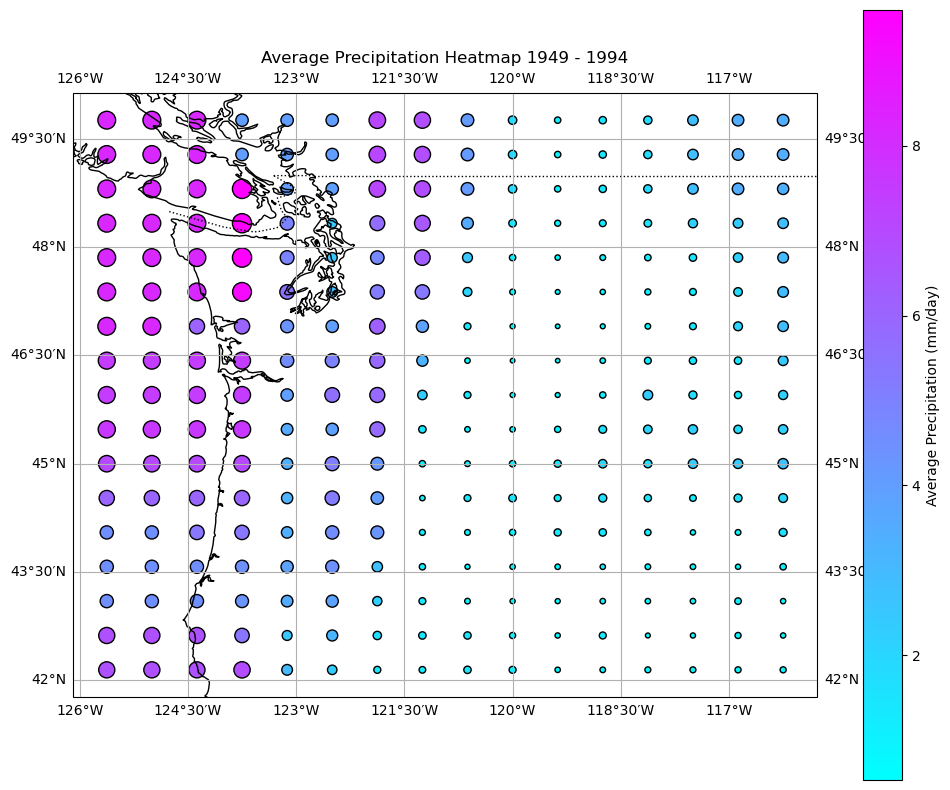

In [ ]:
# Group by latitude and longitude to calculate the mean precipitation
grouped_data = calculate_average_precipitation(df_flat)

plot_title = 'Average Precipitation Heatmap 1949 - 1994'
plot_precipitation_heatmap(grouped_data, plot_title)

In [ ]:
# The bounds of the area to zoom into
min_lon, max_lon = -123, -121
min_lat, max_lat = 46, 48

In [ ]:
# Filter data within the specified area.
filtered_df = filter_data(df_non_zero, min_lon, max_lon, min_lat, max_lat)

# Calculate the average precipitation
average_precip = calculate_average_precipitation(filtered_df)

Data points longitude range: -122.5 to -121.25
Data points latitude range: 46.42768 to 47.85622
Setting extent to: (-123, -121, 46, 48)


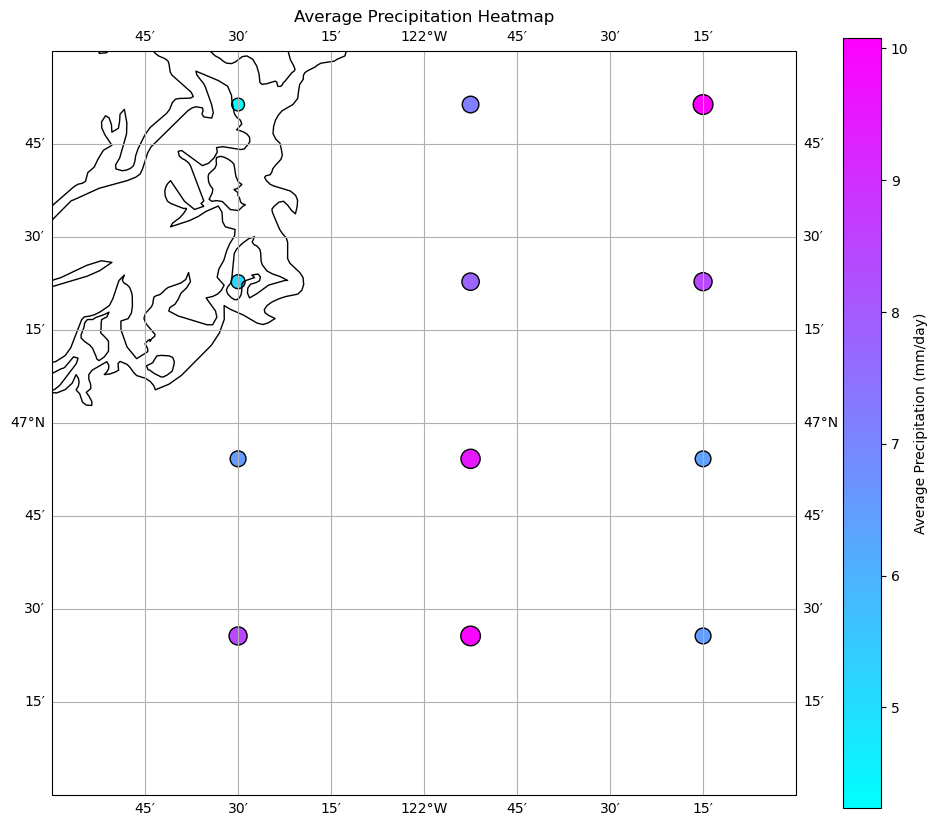

In [ ]:
# Plot the results with a specified extent
plot_title = 'Average Precipitation Heatmap'
plot_precipitation_heatmap(average_precip, plot_title, extent=(min_lon, max_lon, min_lat, max_lat))

In [ ]:
# df_filtered = df_non_zero

# # Group by latitude and longitude to calculate the mean precipitation
# grouped = df_filtered.groupby(['lat', 'lon'])['precipitation'].mean().reset_index()

# # Create a figure with an projection
# fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')

# if not grouped.empty:
#     # Scatter plot for average precipitation
#     sc = ax.scatter(grouped['lon'], grouped['lat'], c=grouped['precipitation'],
#                     cmap='cool', s=150, edgecolor='black', linewidth=1,
#                     transform=ccrs.PlateCarree())  # Ensure the transform is correct
#     plt.colorbar(sc, label='Average Precipitation (mm/day)')
# else:
#     print("No non-zero precipitation data available to plot.")

# # Set the geographic extent to encompass all points or focus on a particular region
# # ax.set_extent([min longitude, max longitude, min latitude, max latitude], crs=ccrs.PlateCarree())
# ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# plt.title('Average Precipitation Heatmap 1949 - 1994')
# plt.show()

Plot specific area

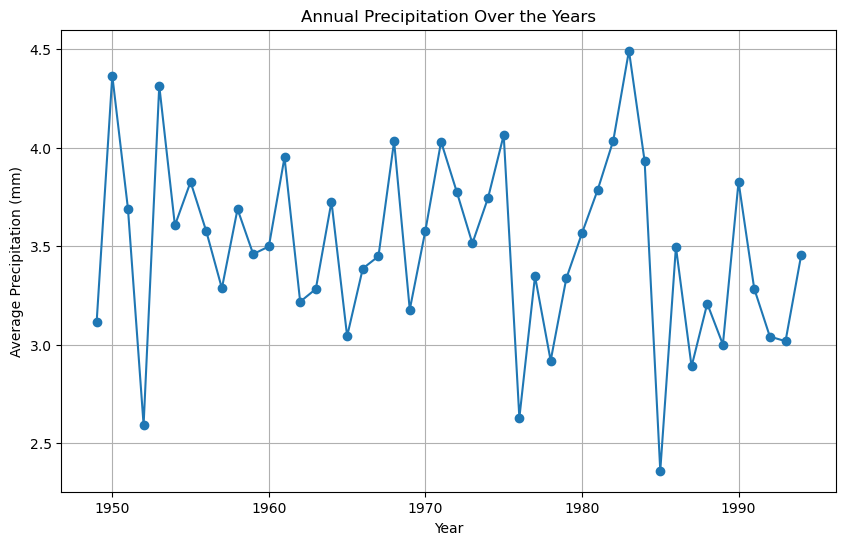

In [ ]:
average_precipitation_df = df_flat.groupby('year')['precipitation'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(average_precipitation_df['year'], average_precipitation_df['precipitation'], marker='o', linestyle='-')
plt.title('Annual Precipitation Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm)')
plt.grid(True)
plt.show()

In [ ]:
central_lat = 46.0
central_lon = -123.0
lat_range = 1.0
lon_range = 1.0

selected_data = filter_data_within_range(df_flat, central_lat, central_lon, lat_range, lon_range)

In [ ]:
# Group by year and calculate average precipitation
average_precipitation_per_year = selected_data.groupby('year')['precipitation'].mean().reset_index()

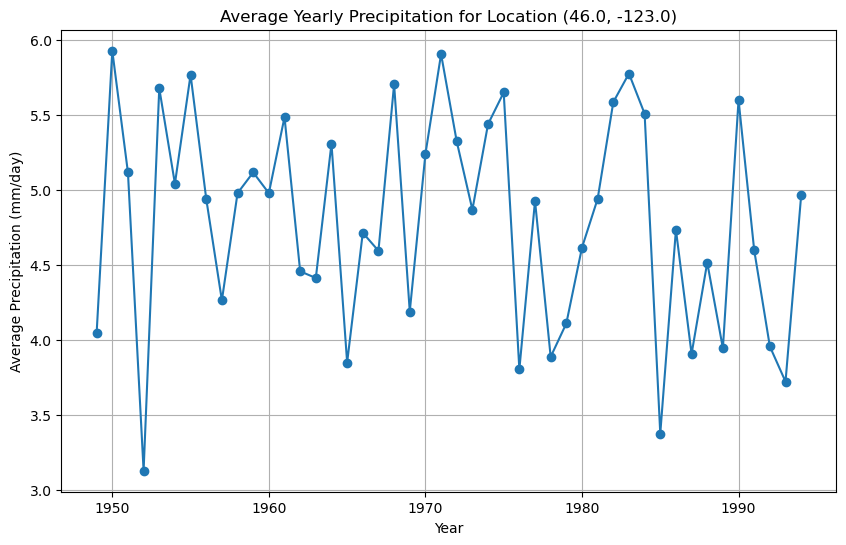

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(average_precipitation_per_year['year'], average_precipitation_per_year['precipitation'], marker='o')
plt.title(f"Average Yearly Precipitation for Location ({central_lat}, {central_lon})")
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm/day)')
plt.grid(True)
plt.show()

 zoom into the specific geographic zone

In [ ]:
# Define the bounds of the area to zoom into
min_lon, max_lon = -117, -0
min_lat, max_lat = 43, 44

df_to_fliter = df_flat
# Filter the data for the specified zone
zone_data = df_to_fliter[(df_to_fliter['lon'] >= min_lon) & (df_to_fliter['lon'] <= max_lon) &
               (df_to_fliter['lat'] >= min_lat) & (df_to_fliter['lat'] <= max_lat)]

In [ ]:
annual_precip = zone_data.groupby('year')['precipitation'].mean().reset_index()

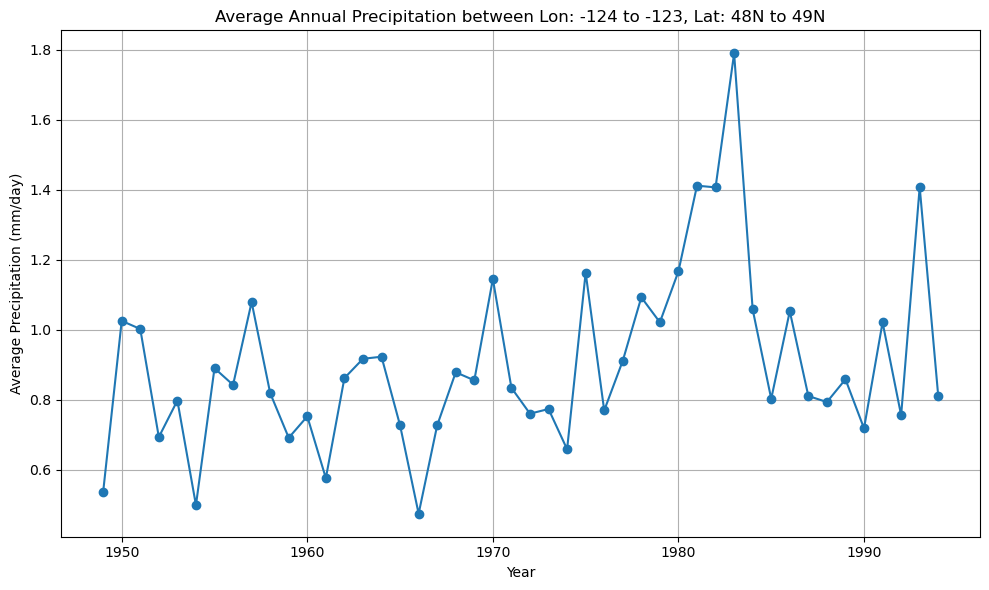

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(annual_precip['year'], annual_precip['precipitation'], marker='o')
plt.title('Average Annual Precipitation between Lon: -124 to -123, Lat: 48N to 49N')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm/day)')
plt.grid(True)
plt.tight_layout()
plt.show()

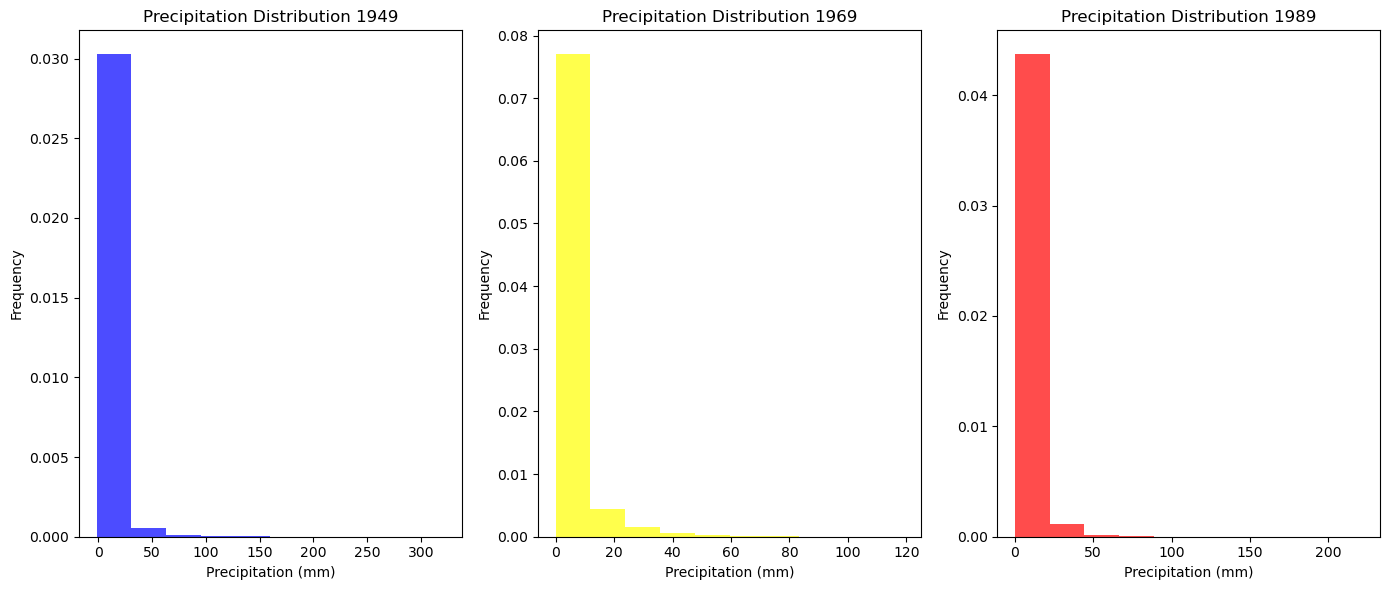

In [ ]:
data_year1 = df_flat[df_flat['year'] == 1949]['precipitation']
data_year2 = df_flat[df_flat['year'] == 1989]['precipitation']
data_year3 = df_flat[df_flat['year'] == 1969]['precipitation']


# Plotting
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

ax[0].hist(data_year1, bins=10, density=True, color='blue', alpha=0.7)
ax[0].set_title('Precipitation Distribution 1949')
ax[0].set_xlabel('Precipitation (mm)')
ax[0].set_ylabel('Frequency')

ax[1].hist(data_year3, bins=10, density=True, color='yellow', alpha=0.7)
ax[1].set_title('Precipitation Distribution 1969')
ax[1].set_xlabel('Precipitation (mm)')
ax[1].set_ylabel('Frequency')

ax[2].hist(data_year2, bins=10, density=True, color='red', alpha=0.7)
ax[2].set_title('Precipitation Distribution 1989')
ax[2].set_xlabel('Precipitation (mm)')
ax[2].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

### K Means Clustering (Lat, Lon)

In [49]:
from sklearn.cluster import KMeans

In [ ]:
import os
# os.environ["OMP_NUM_THREADS"] = "2"
# os.environ["OPENBLAS_NUM_THREADS"] = "4" # export OPENBLAS_NUM_THREADS=4 
# os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
# os.environ["VECLIB_MAXIMUM_THREADS"] = "4" # export VECLIB_MAXIMUM_THREADS=4
# os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6

Elbow method

c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn

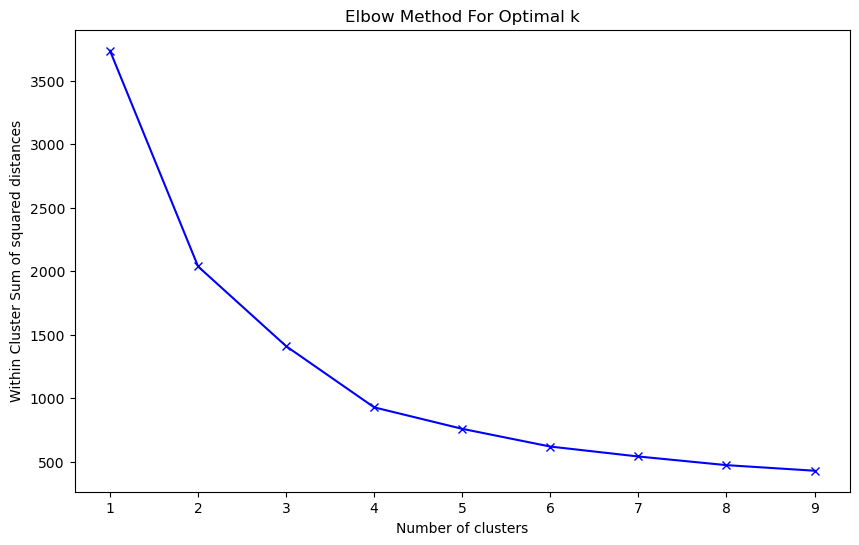

In [438]:
# Calculate the sum of squared distances (SSD) for a range of number of clusters
ssd = []
coords = df_flat[['lat', 'lon']].drop_duplicates().values
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init='auto' ,random_state=42)
    kmeans.fit(coords)
    ssd.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, ssd, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Clustering 

In [50]:
coords = df_flat[['lat', 'lon']].drop_duplicates().values
unique_coords_df = pd.DataFrame(coords, columns=['lat', 'lon'])

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, n_init='auto', random_state=42)

cluster_labels = kmeans.fit_predict(unique_coords_df)

unique_coords_df['location_cluster'] = cluster_labels

df_flat = df_flat.merge(unique_coords_df, on=['lat', 'lon'], how='left')

c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import MultiPoint

def plot_precipitation_heatmap_with_clusters(df_clusters, title, extent=None):
    """
    Creates a geospatial plot of the average precipitation data with extended cluster boundaries.

    Parameters:
    - df_clusters: pandas DataFrame with time-indexed precipitation data for each location cluster
    - title: Title for the plot
    - extent: Optional. A tuple of (min_lon, max_lon, min_lat, max_lat) for the map extent.
              If None, the extent is determined automatically.
    """

    # specifying a specific size for the figure and a PlateCarree projection for the axes
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Group by 'location_cluster', 'lat', and 'lon', and calculate mean precipitation
    grouped_data = df_clusters.groupby(['location_cluster', 'lat', 'lon'])['precipitation'].mean().reset_index()

    size_factor = 20
    point_sizes = grouped_data['precipitation'] * size_factor

    if not grouped_data.empty:

        # creates a scatter plot (sc) of the mean precipitation values at each location cluster. scatter plot take lat and lon as xy cordinates
        # https://scitools.org.uk/cartopy/docs/latest/tutorials/understanding_transform.html
        sc = ax.scatter(grouped_data['lon'], grouped_data['lat'], c=grouped_data['precipitation'],
                        cmap='cool', s=point_sizes, edgecolor='black', linewidth=1,
                        transform=ccrs.PlateCarree()) # Telling Cartopy what coordinate system data are defined in.
        plt.colorbar(sc, label='Average Precipitation (mm/day)')

        # Calculate cluster boundaries (For each cluster)
        clusters = []
        for cluster_label, cluster_group in grouped_data.groupby('location_cluster'):
            cluster_lon = cluster_group['lon']
            cluster_lat = cluster_group['lat']
            # pairs the longitude and latitude values extracted to create a list of coordinate tuples (collection of points in space)
            cluster_points = MultiPoint(list(zip(cluster_lon, cluster_lat)))
            # After having multipoint obj (many xy point in tuples)
            # includes the outermost points of the set and forms a polygon that encloses all the points
            cluster_boundary = cluster_points.convex_hull
            clusters.append((cluster_label, cluster_boundary))

        # Plot cluster boundaries
        # https://stackoverflow.com/questions/55522395/how-do-i-plot-shapely-polygons-and-objects-using-matplotlib 
        for cluster_label, cluster_boundary in clusters:
            if cluster_boundary.geom_type == 'Polygon':
                extended_boundary = cluster_boundary.buffer(0.1)
                #  retrieves the exterior coordinates of the polygon (set of coordinates that define the outer boundary of a polygon)
                coords = np.array(extended_boundary.c)
                # extract all x and y coordinates
                ax.plot(coords[:, 0], coords[:, 1], label=f'Cluster {cluster_label}', linewidth=2)

        ax.legend()
    else:
        print("No data available to plot.")

    if extent:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    else:
        print("Auto-adjusting extent based on data.")

    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    plt.title(title)
    plt.show()

Auto-adjusting extent based on data.


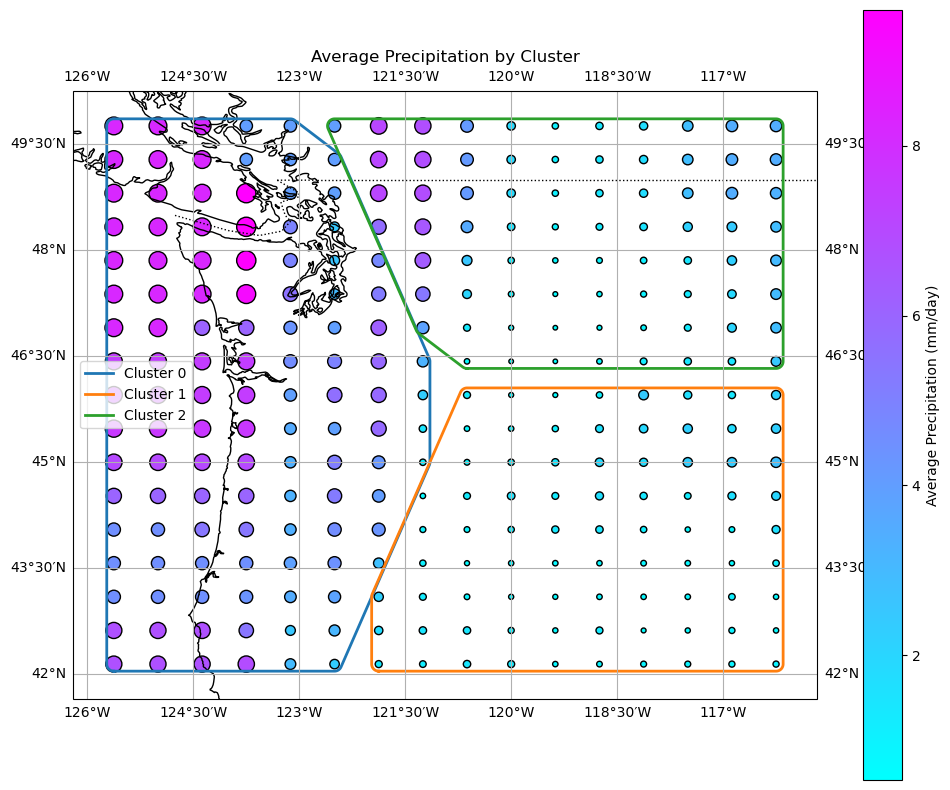

In [ ]:
df_clusters = df_flat[['lat','lon','precipitation', 'location_cluster']]
df_clusters = df_clusters.reset_index(drop=True)
plot_precipitation_heatmap_with_clusters(df_clusters, 'Average Precipitation by Cluster')

In [ ]:
def plot_precipitation_changes(df_clusters, cluster_label, start_year, end_year):
    """
    Plots the changes in precipitation for a specific cluster over consecutive periods.

    Parameters:
    - df_clusters: pandas DataFrame with time-indexed precipitation data for each location cluster
    - cluster_label: The label of the cluster to plot
    - start_year: The starting year for the first period
    - end_year: The ending year for the last period
    """

    interval = end_year - start_year

    cluster_data = df_clusters[df_clusters['location_cluster'] == cluster_label]

    # Filter data for the specified years
    period_data = cluster_data[(cluster_data['year'] >= start_year) & (cluster_data['year'] <= end_year)]

    # Group by year and calculate mean precipitation
    grouped_data = period_data.groupby('year')['precipitation'].mean()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(grouped_data.index, grouped_data.values, marker='o')
    plt.xlabel('Year')
    plt.ylabel('Average Precipitation (mm/day)')
    plt.title(f'Changes in Precipitation for Cluster {cluster_label} over Consecutive {interval}-Year Periods')
    plt.grid(True)
    plt.xticks(grouped_data.index)
    plt.show()


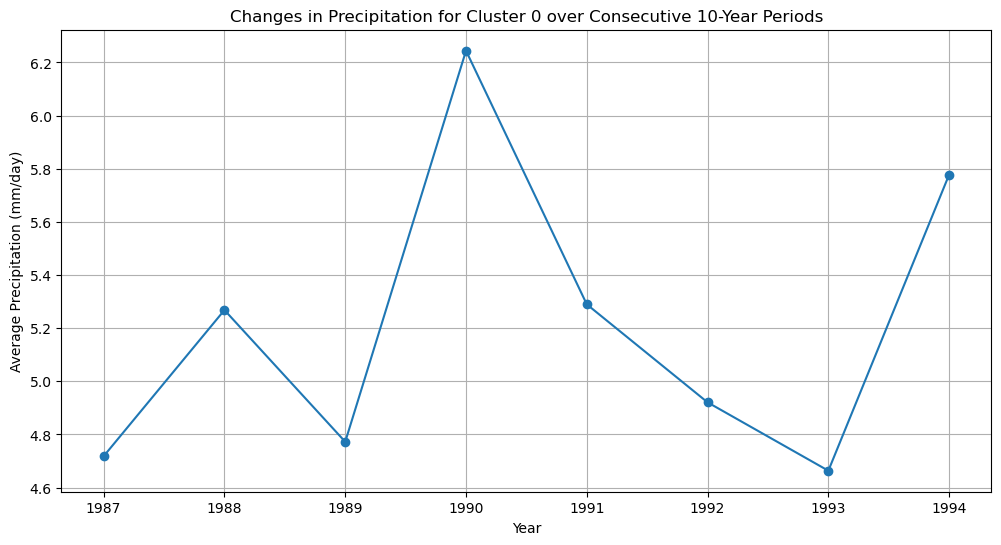

In [ ]:
df_clusters = df_flat[['lat','lon','precipitation', 'location_cluster', 'year']]

df_clusters = df_clusters.reset_index(drop=True)

df_clusters_nonzero = df_clusters[df_clusters['precipitation'] > 0]

plot_precipitation_changes(df_clusters, 0, 1987, 1997)

In [ ]:
df_clusters.set_index('year')

,lat,lon,precipitation,location_cluster
year,,,,
1949,49.76094,-125.625,12.451237,0
1949,49.76094,-125.000,10.839300,0
1949,49.76094,-124.375,9.390542,0
1949,49.76094,-123.750,7.837927,0
1949,49.76094,-123.125,6.168290,0
...,...,...,...,...
1994,42.14206,-118.750,23.900000,1
1994,42.14206,-118.125,25.800001,1
1994,42.14206,-117.500,7.400000,1


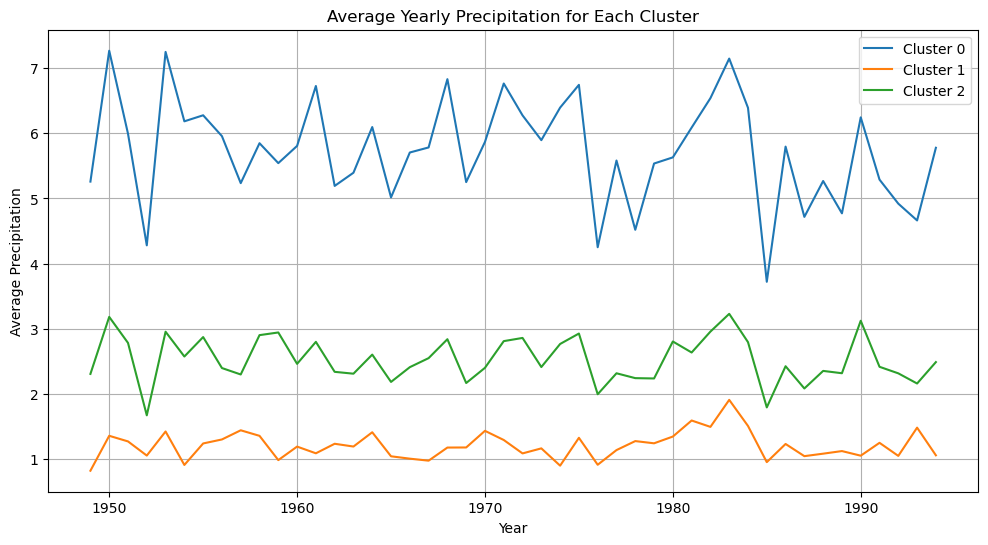

In [ ]:
yearly_avg_precipitation = df_flat.groupby(['location_cluster', 'year'])['precipitation'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
for cluster_label, cluster_data in yearly_avg_precipitation.groupby('location_cluster'):
    plt.plot(cluster_data['year'], cluster_data['precipitation'], label=f'Cluster {cluster_label}')

plt.title('Average Yearly Precipitation for Each Cluster')
plt.xlabel('Year')
plt.ylabel('Average Precipitation')
plt.legend()
plt.grid(True)
plt.show()

### Additive Decomposition

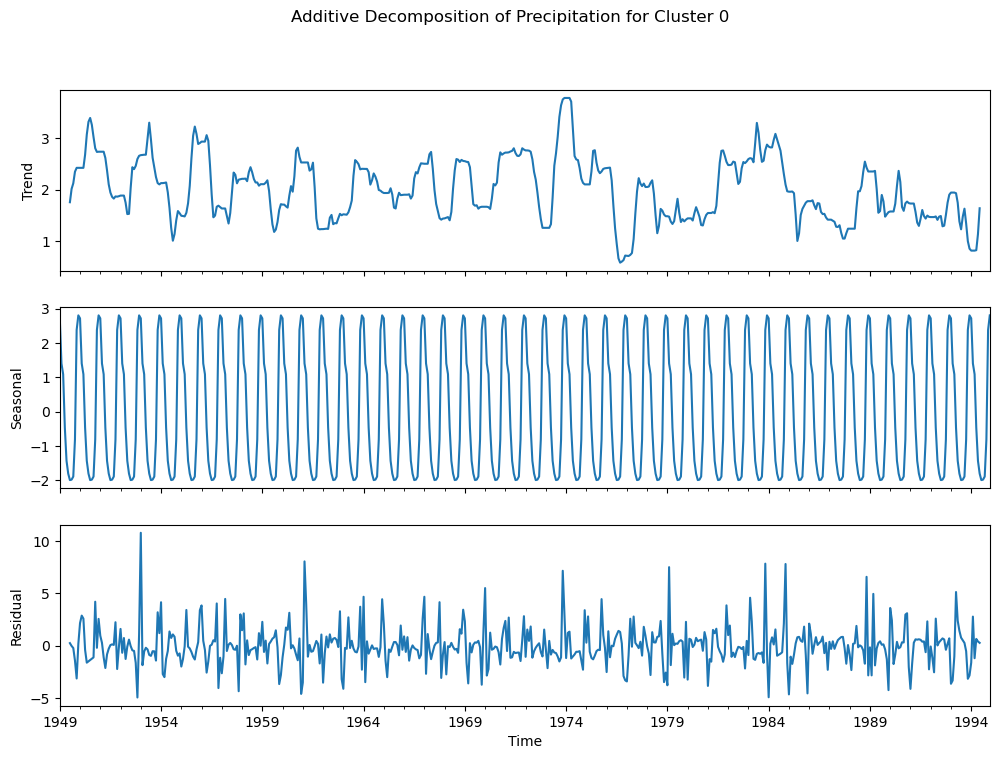

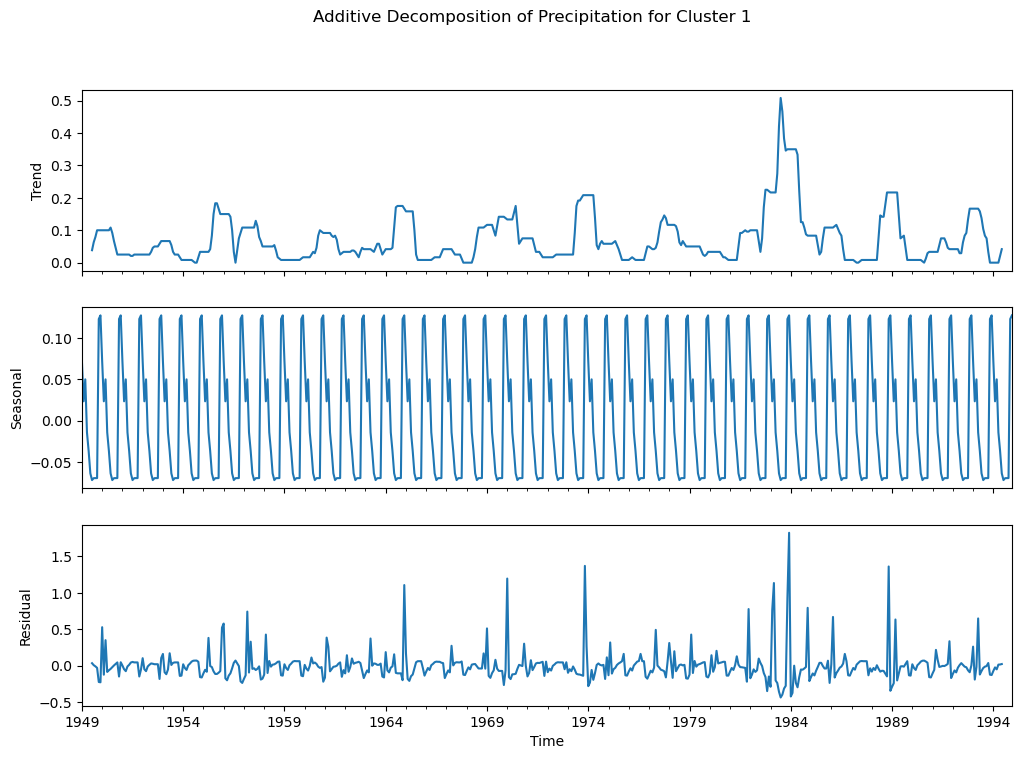

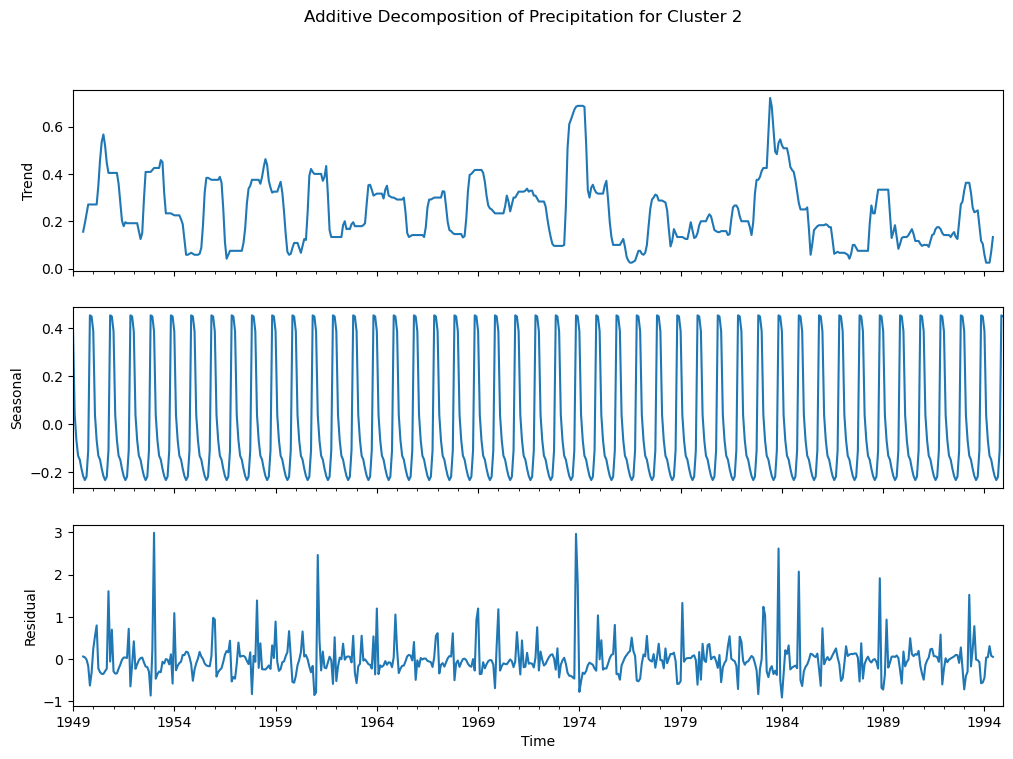

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_clusters = df_flat[['precipitation', 'location_cluster', 'time']]

for cluster_label, cluster_data in df_clusters.groupby('location_cluster'):
    # Resample to ensure there is data for every month
    # cluster_data_resampled = cluster_data.set_index('time').resample('M').mean().fillna(0)

    # cluster_data_resampled_sum = cluster_data.set_index('time').resample('M').sum().fillna(0)

    cluster_data_resampled_median = cluster_data.set_index('time').resample('M').median().fillna(0)
    
    # Decompose the resampled time series
    decomposition = seasonal_decompose(cluster_data_resampled_median ['precipitation'], model='additive')
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plot the decomposed components
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    trend.plot(ax=ax1, legend=False)
    ax1.set_ylabel('Trend')
    seasonal.plot(ax=ax2, legend=False)
    ax2.set_ylabel('Seasonal')
    residual.plot(ax=ax3, legend=False)
    ax3.set_ylabel('Residual')
    
    # Add titles, labels, etc.
    plt.suptitle(f"Additive Decomposition of Precipitation for Cluster {cluster_label}")
    plt.xlabel('Time')
    plt.show()


### Multiplicative Decomposition

multiplicative seasonal decomposition cannot handle zero or negative values
- some precipitation can be 0

C:\Users\User\AppData\Local\Temp\ipykernel_20780\1666973116.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters['precipitation'] += 0.01


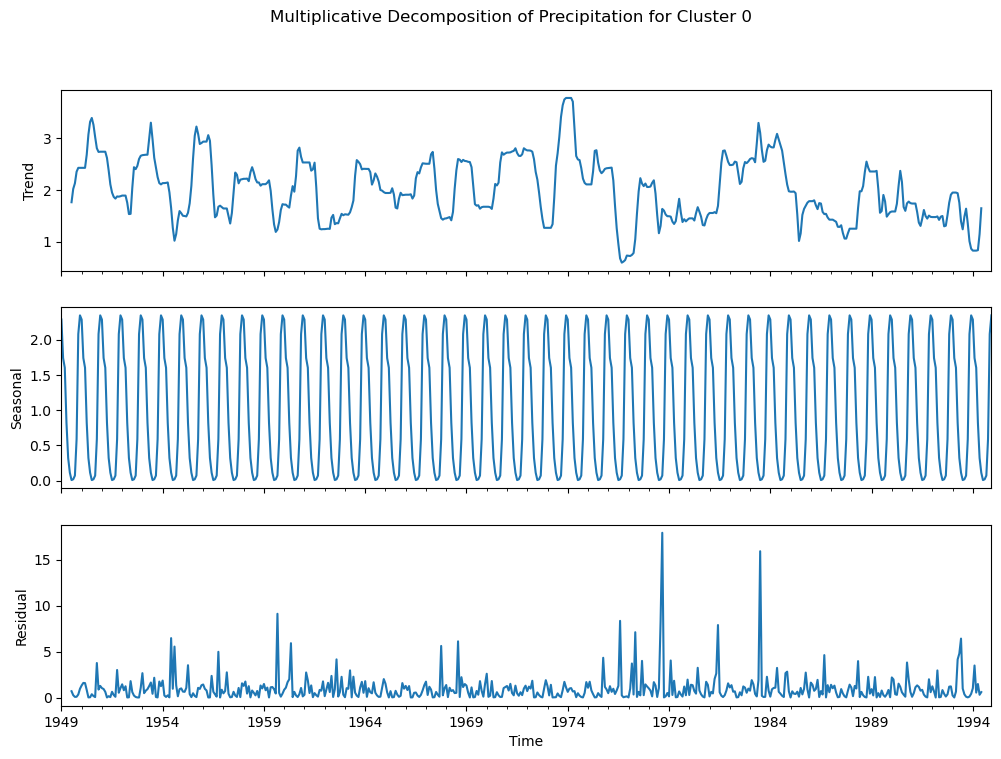

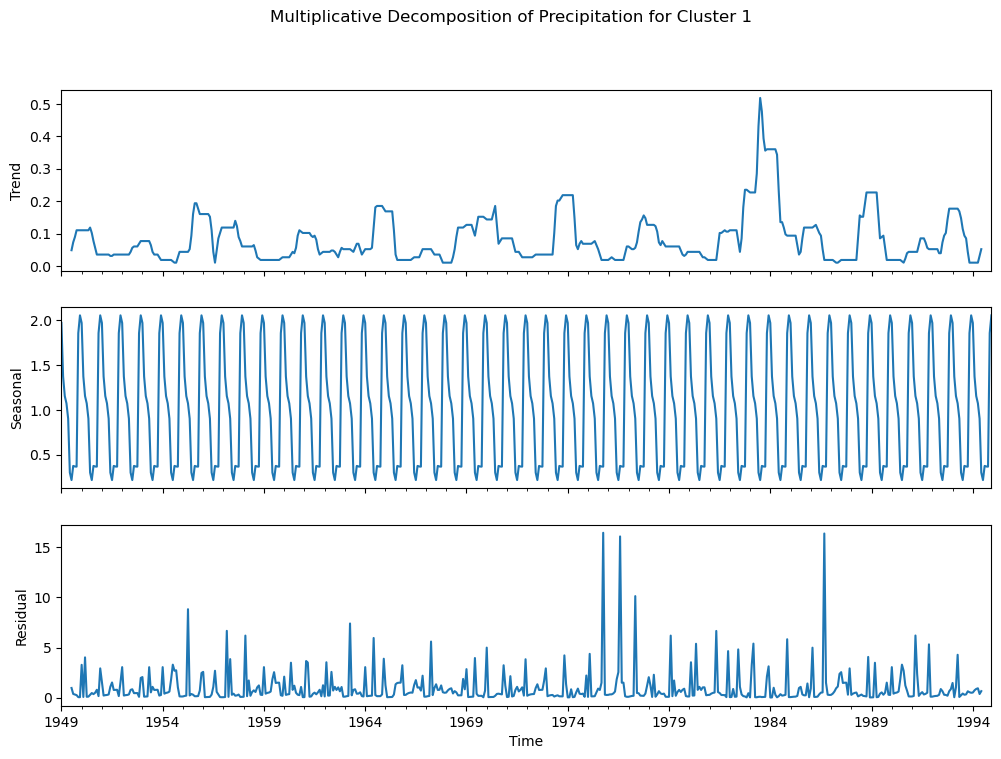

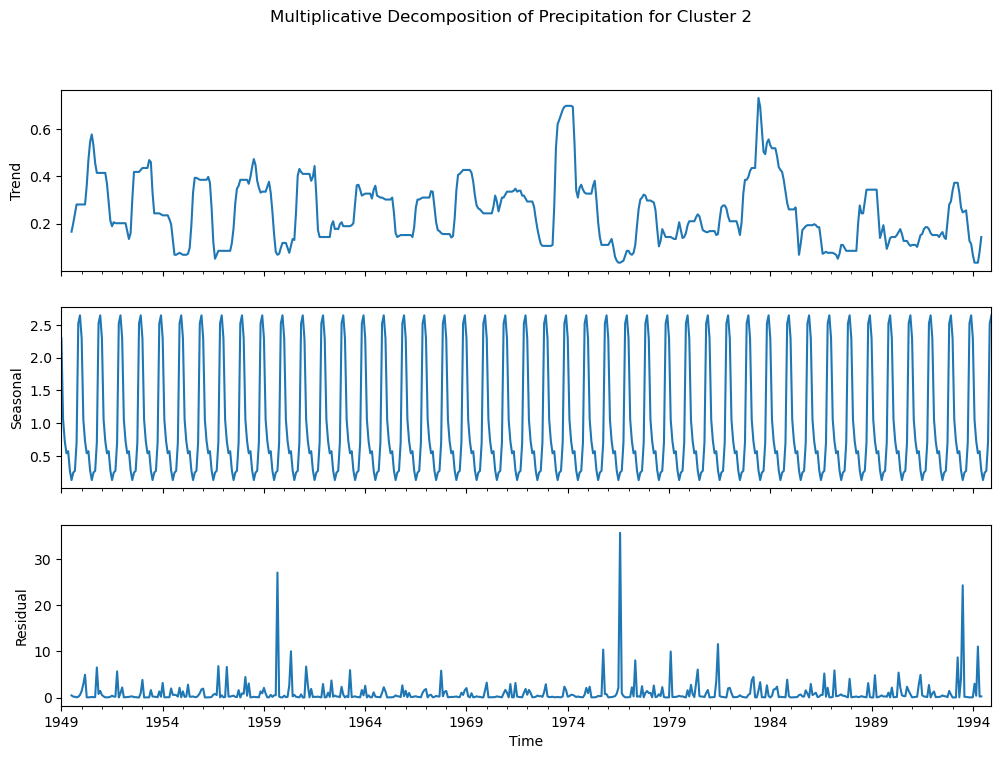

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_clusters = df_flat[['precipitation', 'location_cluster', 'time']]

df_clusters['precipitation'] += 0.01

for cluster_label, cluster_data in df_clusters.groupby('location_cluster'):
    # Resample to ensure there is data for every month
    # cluster_data_resampled = cluster_data.set_index('time').resample('M').mean().fillna(0)

    # cluster_data_resampled_sum = cluster_data.set_index('time').resample('M').sum().fillna(0)

    cluster_data_resampled_median = cluster_data.set_index('time').resample('M').median().fillna(0)
    
    # Decompose the resampled time series
    decomposition = seasonal_decompose(cluster_data_resampled_median['precipitation'], model='multiplicative')
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plot the decomposed components
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    trend.plot(ax=ax1, legend=False)
    ax1.set_ylabel('Trend')
    seasonal.plot(ax=ax2, legend=False)
    ax2.set_ylabel('Seasonal')
    residual.plot(ax=ax3, legend=False)
    ax3.set_ylabel('Residual')
    
    # Add titles, labels, etc.
    plt.suptitle(f"Multiplicative Decomposition of Precipitation for Cluster {cluster_label}")
    plt.xlabel('Time')
    plt.show()

### Augmented Dickey-Fuller test (Stationary test)

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(precipitation_df):

    target = 'precipitation_diff' if 'precipitation_diff' in precipitation_df.columns else 'precipitation'

    for cluster_label, cluster_data in precipitation_df.groupby('location_cluster'):
        result = adfuller(cluster_data[target])
        
        print(f"Cluster {cluster_label}:")
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'   {key}: {value}')
        print()


In [ ]:
# Group by location_cluster and month, calculate the mean precipitation
monthly_avg_precipitation = df_flat.groupby(['location_cluster', df_flat['time'].dt.month])['precipitation'].mean().reset_index()

adfuller_test(monthly_avg_precipitation)

Cluster 0:
ADF Statistic: -2.965459202634706
p-value: 0.038248417424994796
Critical Values:
   1%: -4.331573
   5%: -3.23295
   10%: -2.7487

Cluster 1:
ADF Statistic: -3.158995229296673
p-value: 0.022484304647853972
Critical Values:
   1%: -4.9386902332361515
   5%: -3.477582857142857
   10%: -2.8438679591836733

Cluster 2:
ADF Statistic: -1.9876186745969395
p-value: 0.29202812627648356
Critical Values:
   1%: -4.331573
   5%: -3.23295
   10%: -2.7487



### ACF & PACF

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(df_clusters, target='precipitation', differencing=False):
    for cluster_label, cluster_data in df_clusters.groupby('location_cluster'):
        # Plot ACF
        fig, ax = plt.subplots(figsize=(12, 6))
        plot_acf(cluster_data[target], lags=40, ax=ax)
        ax.set_title(f'ACF for Cluster {cluster_label} (Differencing = {differencing})')
        plt.show()

        # Plot PACF
        fig, ax = plt.subplots(figsize=(12, 6))
        plot_pacf(cluster_data[target], lags=40, ax=ax)
        ax.set_title(f'PACF for Cluster {cluster_label} (Differencing = {differencing})')
        plt.show()

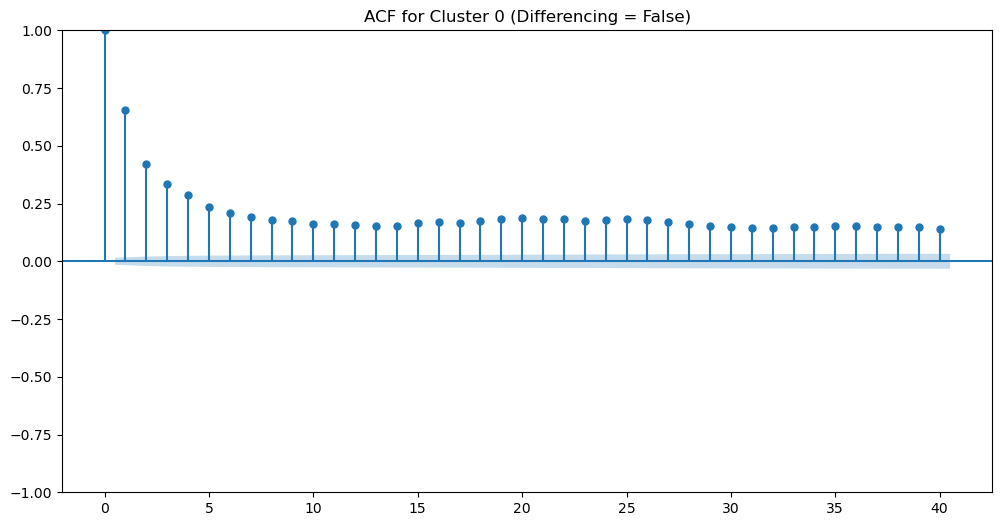

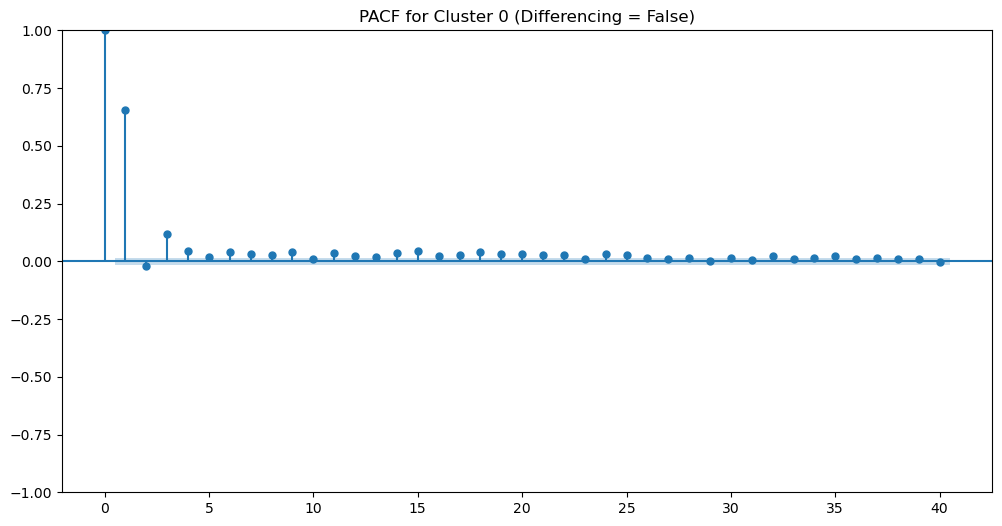

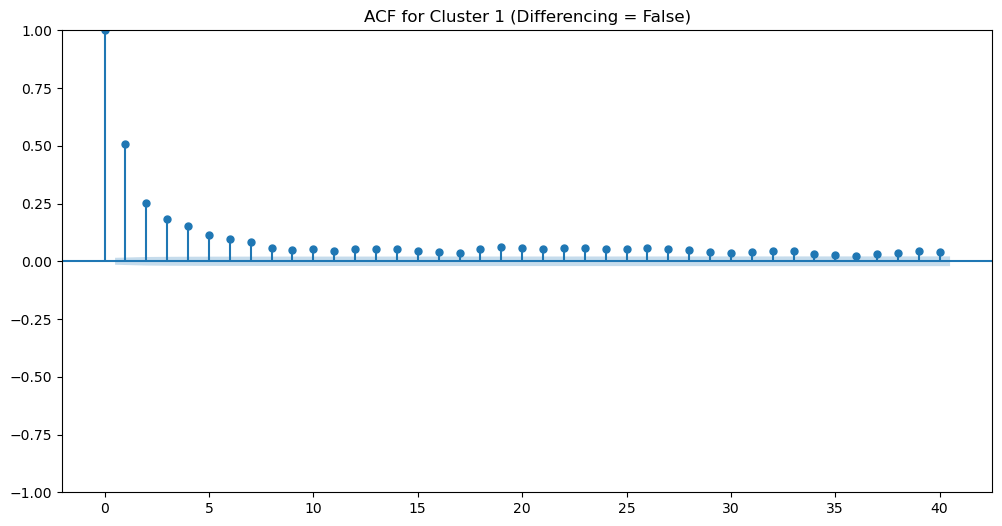

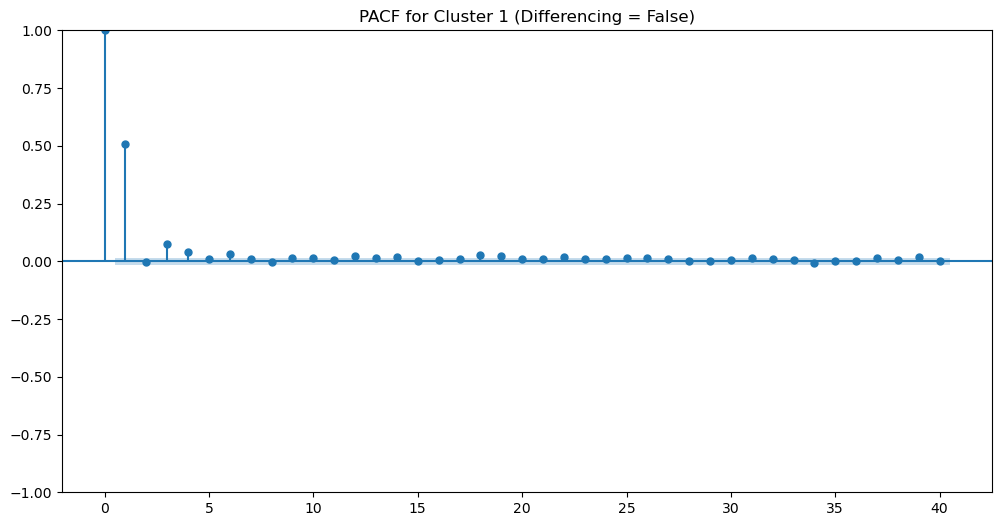

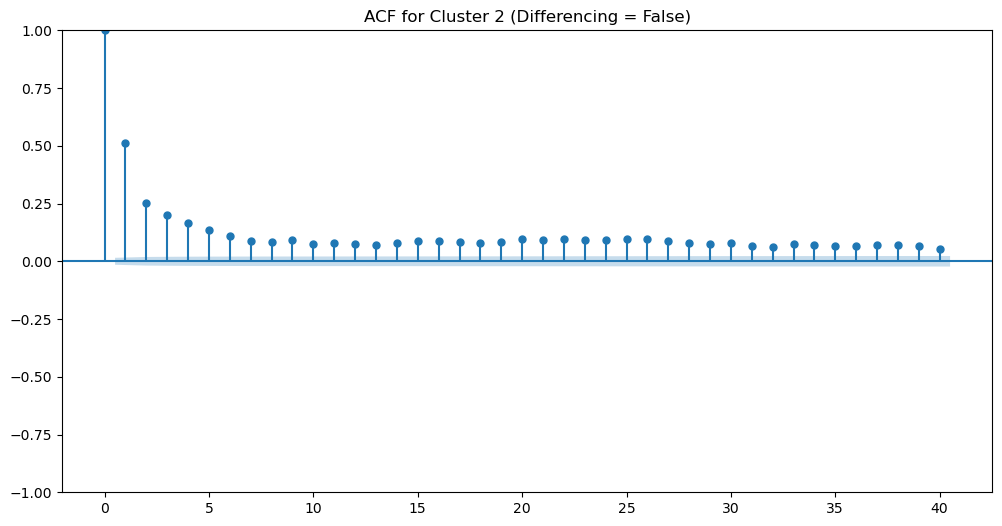

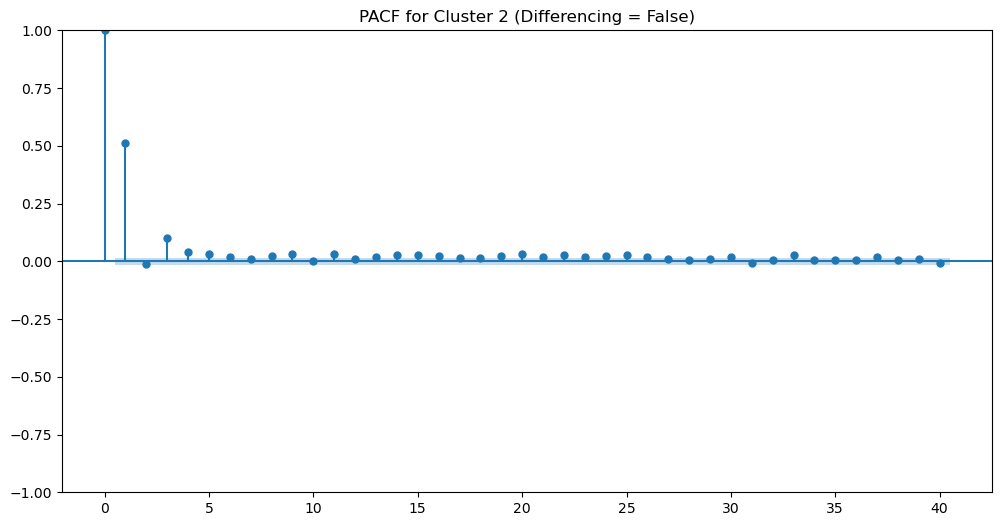

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df_clusters = df_flat[['precipitation', 'location_cluster', 'time']]

df_clusters = df_clusters.groupby(['time', 'location_cluster']).agg({'precipitation': 'mean'}).reset_index()

plot_acf_pacf(df_clusters, target='precipitation', differencing=False)

Corr heatmap

C:\Users\User\AppData\Local\Temp\ipykernel_20780\1076382932.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_flat.corr()


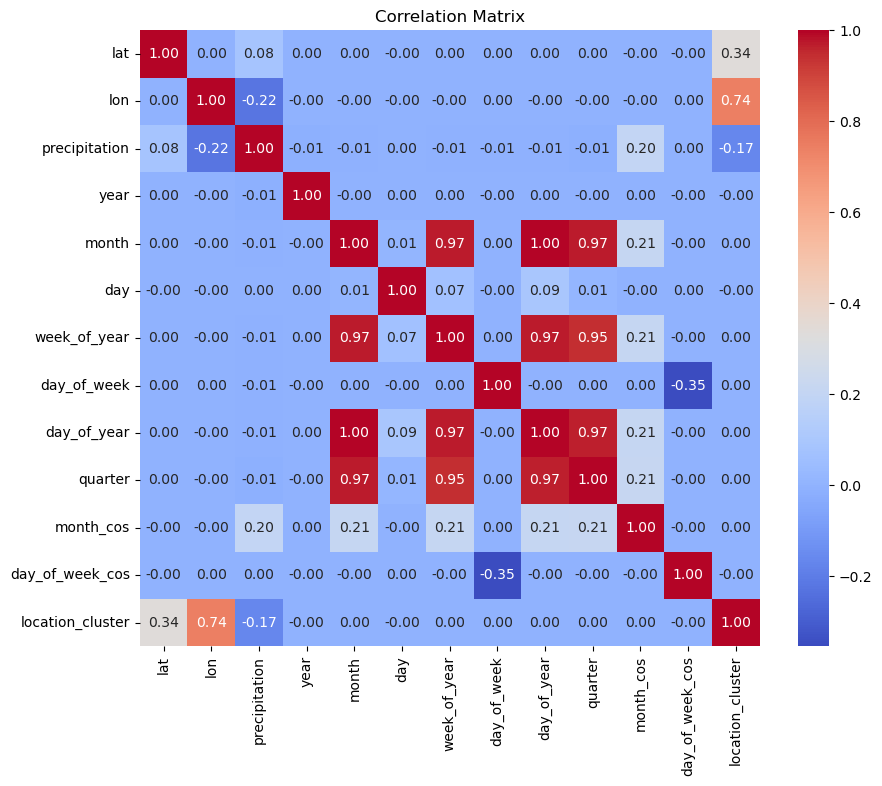

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df_flat.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

## Differencing

In [105]:
# Sort the DataFrame by 'location_cluster' and 'time'
df_clusters_diff = df_flat.sort_values(by=['location_cluster', 'time'])

# Perform differencing for each 'location_cluster'
df_clusters_diff['precipitation_diff'] = df_clusters_diff.groupby('location_cluster')['precipitation'].diff(1)

# Remove NaN
df_clusters_diff.sort_values('time', inplace=True)
df_clusters_diff = df_clusters_diff.iloc[3:]

In [106]:
df_clusters_diff = df_clusters_diff.drop(['precipitation','lat', 'lon'], axis=1)

### Resample data

In [41]:
from sklearn.preprocessing import RobustScaler

def robust_scaling(cluster_data):
    key = 'precipitation_diff' if 'precipitation_diff' in cluster_data.columns else 'precipitation'

    scaler = RobustScaler()
    cluster_data_scaled = scaler.fit_transform(cluster_data[[key]])
    
    cluster_data[key + '_scaled'] = cluster_data_scaled
    
    return cluster_data

In [42]:
from sklearn.preprocessing import MinMaxScaler

def min_max_scalling(cluster_data):

    key = 'precipitation_diff' if 'precipitation_diff' in cluster_data.columns else 'precipitation'

    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(cluster_data[[key]])
    cluster_data_scaled = cluster_data.copy()
    cluster_data_scaled[key] = scaled_values
    
    return cluster_data_scaled

In [43]:
def clip_negative_value(cluster_data, clip=True, lower_value=0):
    
    key = 'precipitation_diff' if 'precipitation_diff' in cluster_data.columns else 'precipitation'

    if clip:
        # Clip negative values in precipitation_diff to 0
        cluster_data[key] = cluster_data[key].clip(lower=lower_value).copy()
    else:
        cluster_data[key] = cluster_data[key]

    return cluster_data

In [44]:
def extract_process_cluster_data(df_clusters, cluster: int, clip, scale):
    # Clip (Limit) negative value and extract specific cluster

    # Extract specific cluster
    cluster_data = df_clusters[df_clusters['location_cluster'] == cluster].copy()

    if clip is True:
        cluster_data = clip_negative_value(cluster_data, lower_value=0)

       
    if scale is True and clip is False:
        cluster_data = min_max_scalling(cluster_data)
        # cluster_data = robust_scaling(cluster_data)

    # Drop precipitation and location_cluster columns
    # cluster_data_clipped.drop(['precipitation', 'location_cluster'], axis=1, inplace=True)

    if 'time' not in cluster_data.index.names:
        # Ensure the 'time' column is a datetime-like object
        cluster_data['time'] = pd.to_datetime(cluster_data['time'])
        # Set the 'time' column as the index
        cluster_data.set_index('time', inplace=True) 


    return cluster_data

In [45]:
def process_all_clusters(df_clusters, resample_interval ='3M', resample_calculation = 'mean', clip=True, scale =False):
    # Clip negative values, resample time for each cluster data and combine

    # List to store processed cluster data
    processed_clusters = []

    # Iterate over each cluster
    for cluster_id in df_clusters['location_cluster'].unique():
        # Extract and process data for the current cluster
        cluster_data_clipped = extract_process_cluster_data(df_clusters, cluster_id, clip, scale)

        # Check if 'precipitation_diff' is in the df
        key = 'precipitation_diff' if 'precipitation_diff' in df_clusters.columns else 'precipitation'

        # Resample data
        if resample_calculation.lower() == 'median':
            seasonal_precipitation = cluster_data_clipped[key].resample(resample_interval).median()
        elif resample_calculation.lower() == 'mean':
            seasonal_precipitation = cluster_data_clipped[key].resample(resample_interval).mean()     
        else:
            # sum up all precipitation at same time
            seasonal_precipitation = cluster_data_clipped[key].resample(resample_interval).sum()

        seasonal_precipitation = seasonal_precipitation.reset_index()
        seasonal_precipitation.set_index('time', inplace=True)

        # Add cluster_id column for identification
        seasonal_precipitation['location_cluster'] = cluster_id

        # Append processed cluster data to the list
        processed_clusters.append(seasonal_precipitation)

    # Concatenate processed cluster data into a single DataFrame
    processed_df = pd.concat(processed_clusters)

    return processed_df

In [346]:
def reverse_diff_and_clip(df_clusters_diff, cluster):
    # Get the key for precipitation
    key = 'precipitation_diff' if 'precipitation_diff' in df_clusters_diff.columns else 'precipitation'
    
    # Extract data for the specific cluster
    cluster_data = df_clusters_diff[df_clusters_diff['location_cluster'] == cluster].copy()
    
    # Reverse the clipping
    cluster_data[key] = cluster_data[key].clip(0, None)
    
    # Reverse the differencing
    cluster_data['reversed_precipitation'] = cluster_data[key].cumsum()
    
    return cluster_data

In [46]:
def reverse_diff_and_clip_forecasts(forecasts):
    reversed_forecasts = {}
    for cluster, data in forecasts.items():
        # Reverse the clipping
        data = data.clip(0, None)
        
        # Reverse the differencing
        reversed_data = data.cumsum()
        
        # Store the reversed data
        reversed_forecasts[cluster] = reversed_data
    
    return reversed_forecasts

### Perform Resample then differencing

In [51]:
df_flat_resampled = process_all_clusters(df_flat, resample_interval='3M', resample_calculation='mean', clip=True, scale=False)

In [536]:
# Sort the DataFrame by 'location_cluster' and 'time'
df_clusters_resampled = df_flat_resampled.sort_values(by=['location_cluster', 'time'])

# Perform differencing for each 'location_cluster'
df_clusters_resampled['precipitation_diff'] = df_clusters_resampled.groupby('location_cluster')['precipitation'].diff(1)

# Remove NaN
df_clusters_resampled.sort_values('time', inplace=True)
df_clusters_resampled= df_clusters_resampled.iloc[3:]

df_clusters_resampled = df_clusters_resampled.drop(['precipitation'], axis=1)

In [497]:
# df_clusters_resampled = df_clusters_resampled.drop(['lat', 'lon'], axis=1)

In [503]:
# df_clusters_resampled = derive_temporal_features(df_clusters_resampled.reset_index())

In [504]:
# df_clusters_resampled

,time,location_cluster,precipitation_diff,year,month,day,week_of_year,day_of_week,day_of_year,quarter,season,month_cos,day_of_week_cos
0,1949-04-30,0,5.842203,1949,4,30,17,5,120,2,Spring,-0.500000,-0.222521
1,1949-04-30,1,0.672877,1949,4,30,17,5,120,2,Spring,-0.500000,-0.222521
2,1949-04-30,2,2.137655,1949,4,30,17,5,120,2,Spring,-0.500000,-0.222521
3,1949-07-31,0,-6.352048,1949,7,31,30,6,212,3,Summer,-0.866025,0.623490
4,1949-07-31,1,-0.405034,1949,7,31,30,6,212,3,Summer,-0.866025,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,1994-10-31,0,1.186928,1994,10,31,44,0,304,4,Fall,0.500000,1.000000
548,1994-10-31,1,-0.464962,1994,10,31,44,0,304,4,Fall,0.500000,1.000000
549,1995-01-31,1,1.401918,1995,1,31,5,1,31,1,Winter,0.866025,0.623490
550,1995-01-31,0,9.859205,1995,1,31,5,1,31,1,Winter,0.866025,0.623490


In [505]:
# df_clusters_resampled.to_csv('processed_cluster_data_diff_3months_mean.csv')

ADF on Diff Data

In [537]:
df_clusters_diff_adf = df_clusters_resampled

In [538]:
adfuller_test(df_clusters_diff_adf)

Cluster 0:
ADF Statistic: -30.58811916496846
p-value: 0.0
Critical Values:
   1%: -3.4307403259771614
   5%: -2.8617125085240045
   10%: -2.566861821893139

Cluster 1:
ADF Statistic: -30.9673303180821
p-value: 0.0
Critical Values:
   1%: -3.4307403492768214
   5%: -2.8617125188208488
   10%: -2.5668618273740047

Cluster 2:
ADF Statistic: -30.589703408737886
p-value: 0.0
Critical Values:
   1%: -3.4307403492768214
   5%: -2.8617125188208488
   10%: -2.5668618273740047



ACF & PACF after differencing

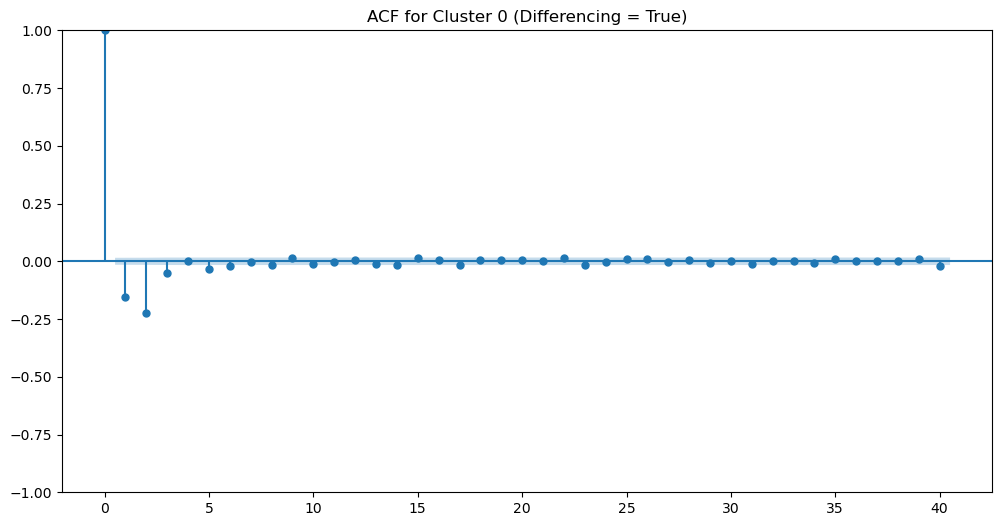

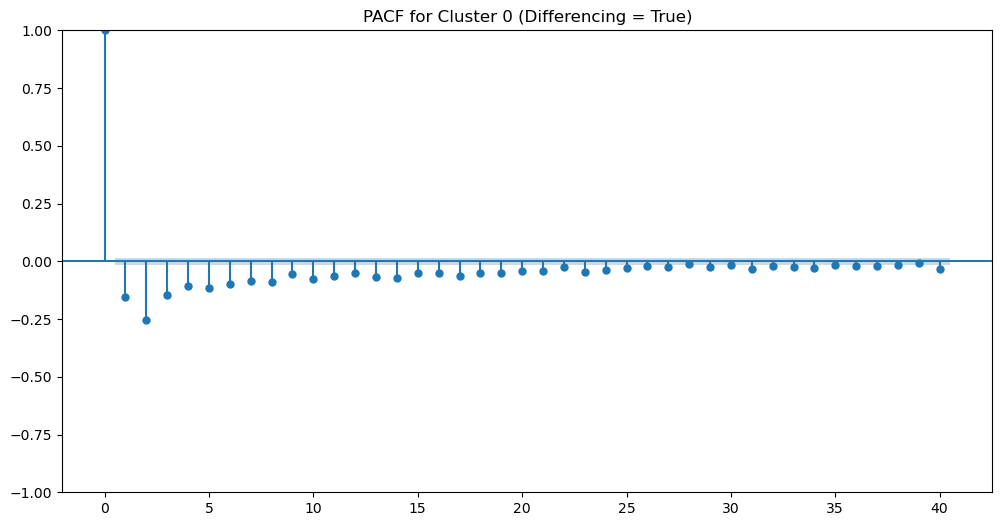

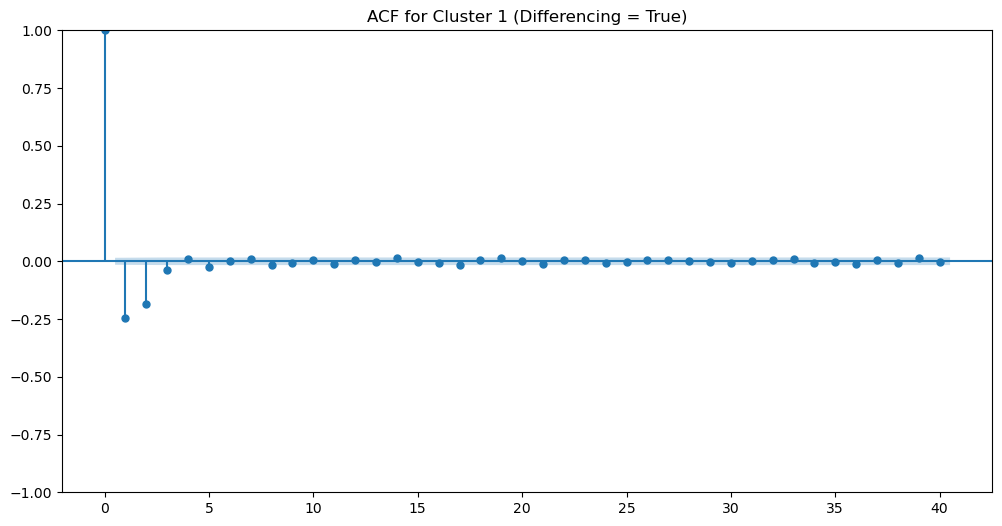

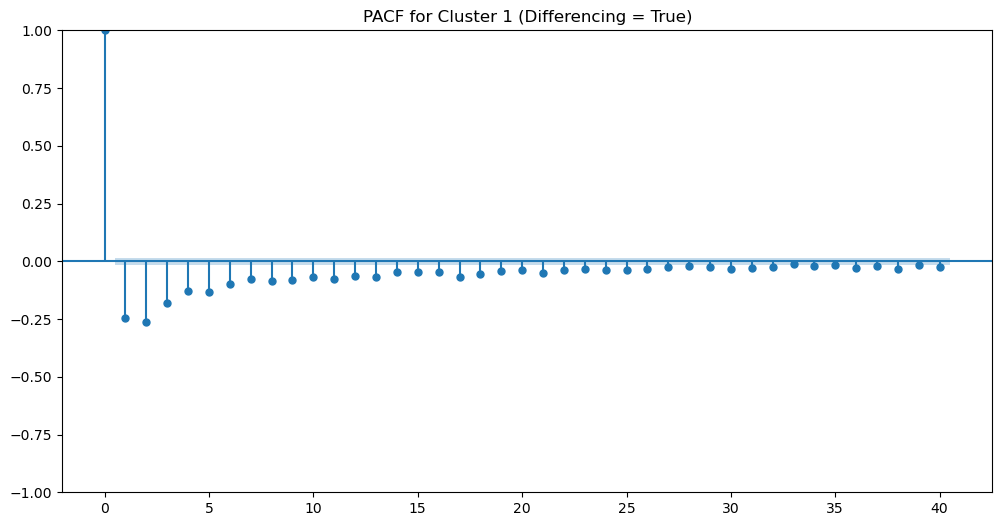

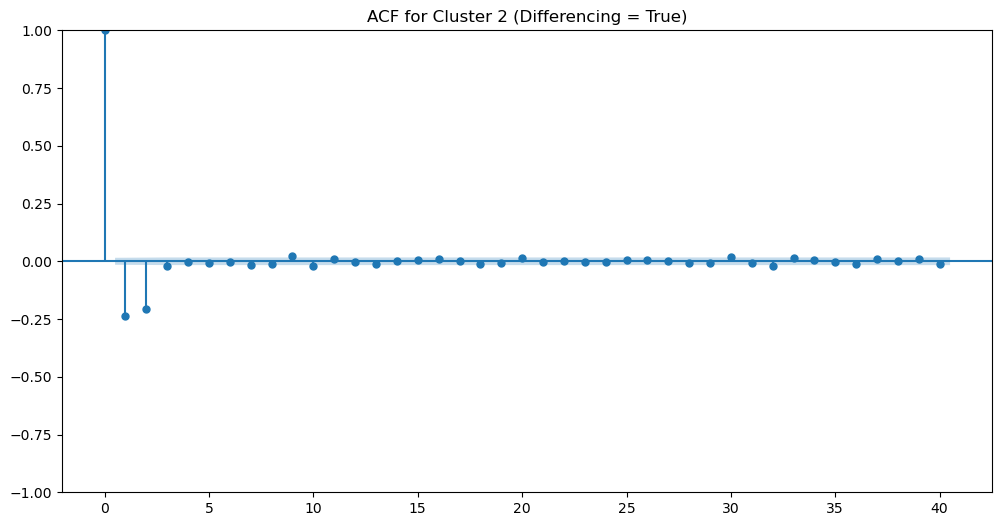

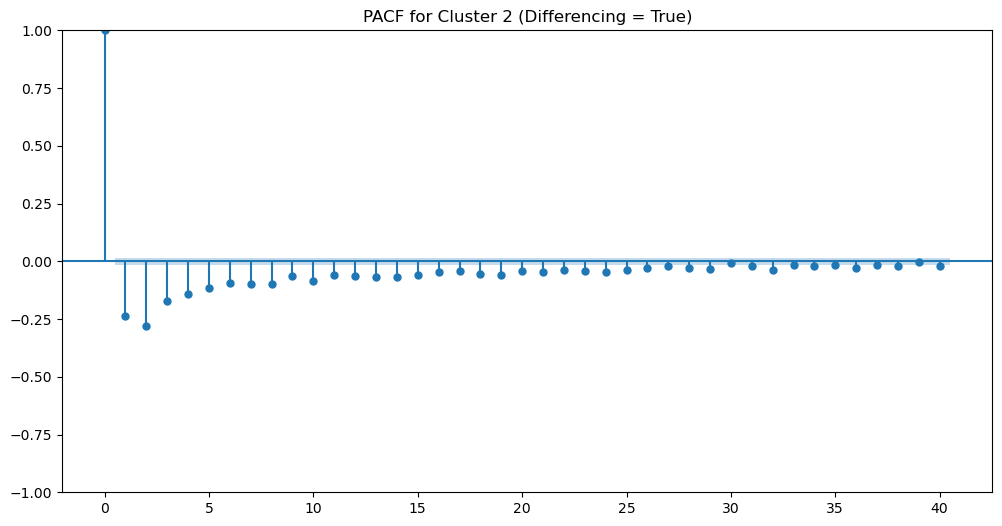

In [539]:
plot_acf_pacf(df_clusters_diff_adf, target='precipitation_diff', differencing=True)

In [520]:
import numpy as np

Baseline

In [ ]:
baseline_df = df_clusters_resampled

In [522]:
from sklearn.metrics import mean_squared_error

In [516]:
target = 'precipitation_diff' if 'precipitation_diff' in baseline_df.columns else 'precipitation'

for cluster_id in baseline_df['location_cluster'].unique():
    # Filter data for the current cluster
    cluster_data = baseline_df[baseline_df['location_cluster'] == cluster_id]
    
    # Calculate mean and median for the target variable within this cluster
    mean_value = cluster_data[target].mean()
    median_value = cluster_data[target].median()
    
    # Store these baseline predictions back into the DataFrame
    baseline_df.loc[baseline_df['location_cluster'] == cluster_id, 'mean_prediction'] = mean_value
    baseline_df.loc[baseline_df['location_cluster'] == cluster_id, 'median_prediction'] = median_value

if target in baseline_df.columns:
    overall_rmse_mean = np.sqrt(mean_squared_error(baseline_df[target], baseline_df['mean_prediction']))
    overall_rmse_median = np.sqrt(mean_squared_error(baseline_df[target], baseline_df['median_prediction']))
    
    print(f'Overall Mean Predictor RMSE: {overall_rmse_mean}')
    print(f'Overall Median Predictor RMSE: {overall_rmse_median}')

Overall Mean Predictor RMSE: 5.45816964295639
Overall Median Predictor RMSE: 5.45832614344415


In [472]:
if target in baseline_df.columns:
    # Calculate RMSE for each cluster and overall
    for cluster_id in baseline_df['location_cluster'].unique():
        cluster_data = baseline_df[baseline_df['location_cluster'] == cluster_id]
        rmse_mean = np.sqrt(mean_squared_error(cluster_data[target], cluster_data['mean_prediction']))
        rmse_median = np.sqrt(mean_squared_error(cluster_data[target], cluster_data['median_prediction']))
        
        print(f'Cluster {cluster_id} - Mean Predictor RMSE: {rmse_mean:.4f}, Median Predictor RMSE: {rmse_median:.4f}')

Cluster 0 - Mean Predictor RMSE: 6.7366, Median Predictor RMSE: 6.7366
Cluster 1 - Mean Predictor RMSE: 1.7755, Median Predictor RMSE: 1.7755
Cluster 2 - Mean Predictor RMSE: 3.0059, Median Predictor RMSE: 3.0059


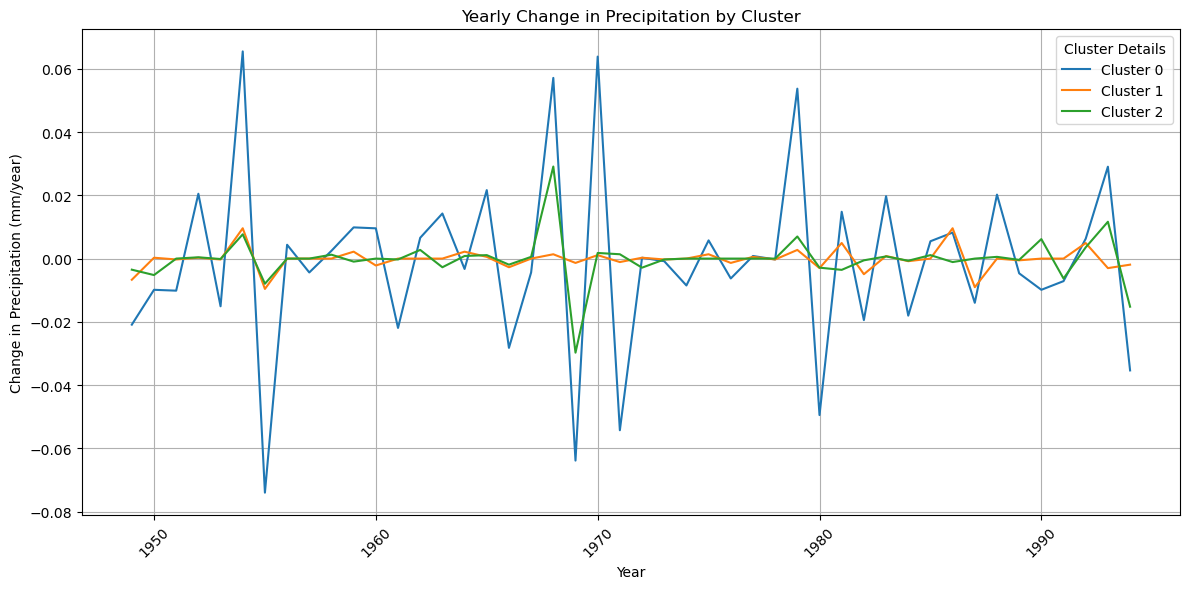

In [473]:
baseline_df = derive_temporal_features(baseline_df.reset_index())

yearly_avg_precipitation = baseline_df.groupby(['location_cluster', 'year'])[target].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
for cluster_label, cluster_data in yearly_avg_precipitation.groupby('location_cluster'):
    plt.plot(cluster_data['year'], cluster_data[target], label=f'Cluster {cluster_label} ')

plt.title('Yearly Change in Precipitation by Cluster')
plt.xlabel('Year')
plt.ylabel('Change in Precipitation (mm/year)')
plt.legend(title='Cluster Details')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Output Dataset

In [351]:
# df_flat = df_flat.drop(['lat', 'lon'], axis=1)

In [390]:
# df_clusters = process_all_clusters(df_flat, resample_interval='M', resample_calculation='sum', clip=False, scale=True)

In [291]:
# df_clusters = derive_temporal_features(df_clusters.reset_index())

In [292]:
# df_clusters.to_csv('cluster_data_precipitation_month_sum_scaled.csv')

In [204]:
# processed_cluster_data = process_all_clusters(df_clusters_diff, resample_interval='M', resample_calculation='sum', clip=False, scale=True)

In [205]:
# processed_cluster_data

,precipitation_diff,location_cluster
time,,
1949-01-31,1.010183,2
1949-02-28,0.000000,2
1949-03-31,0.000000,2
1949-04-30,0.800000,2
1949-05-31,7.800000,2
...,...,...
1994-08-31,0.000000,0
1994-09-30,0.000000,0
1994-10-31,0.000000,0


In [206]:
# processed_cluster_data = derive_temporal_features(processed_cluster_data.reset_index())

In [203]:
# processed_cluster_data.to_csv('processed_cluster_data_diff.csv')